# Дипломная работа:
## Построение скоринг модели для клиентов банка, которая предсказывает вероятность дефолта клиента исходя из анкетных данных, портфельных данных банка, кредитной истории клиента в кредитном бюро и соц.отчислениях из центра выплаты пенсий

### Импортируем библиотеки

In [80]:
from pandas import Series
import pandas as pd
import numpy as np
from datetime import date
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
import os
from tqdm import tqdm
import sys
import random
import pandas_profiling

from bs4 import BeautifulSoup
import requests 
import csv
from threading import Thread
import queue
import time
import scikit_posthocs as sp

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif, mutual_info_classif
from catboost import CatBoostRegressor, CatBoostClassifier, Pool, cv
import sklearn.metrics
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingRegressor, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score
import optuna
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import plot_confusion_matrix
import scikitplot as skplt

# plotly standard imports
import plotly.graph_objs as go

# Cufflinks wrapper on plotly
import cufflinks


# Options for pandas
pd.options.display.max_columns = 30

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from plotly.offline import iplot
cufflinks.go_offline()

### Используемые функции для обработки и визуализации

In [177]:
def VizCounterBar(df, column, title, max_values=0):
    """
    Визуализация количества значений в dataframe
    df - датафрейм, column - столбец, title - подпись
    max_values - максимальное количество значений для отображения/ 0 - все
    """
    
    if max_values >0:
        col_values = df[column].value_counts().nlargest(max_values).sort_values(ascending=True)
    else:
        col_values = df[column].value_counts(ascending=True)
    
    fig, ax = plt.subplots()
    plt.rcParams['figure.figsize'] = (12,12)
    plt.figure 
       
    ax = col_values.plot(kind='barh', title = title)
    ax.set_facecolor('lightgrey')
    ax.set_xlim(0, col_values.max()*1.15)
    
    for i, v in enumerate(col_values):
        plt.text(v, i, " "+str(v), va='center')
    
    plt.show()
    
def ShowPlotsLog(column):
    """
    Визуализация распределения значений столбца в dataframe после логарифмирования
    column - столбец в dataframe
    """
        
    df[column]=np.log(df[column]+1)
    df[column].hist(figsize=(10,5))

def Log(column):
    """
     логарифмированиt данных
    column - столбец в dataframe
    """
        
    df[column]=np.log(df[column]+1)   
    
    
def ShowBoxPlots(column):
    """
    Boxplot относительно целевой переменной в dataframe
    column - столбец в dataframe
    x - целевая переменная 
    """
    fig,ax=plt.subplots(figsize=(10,4))
    sns.boxplot(y=column,x='Default', data=df)
    plt.title(column)
    plt.show()
    
def Outliers(column):
    """
    Определение квартилей и границ выбросов для признаков в dataframe
    column - столбец в dataframe
    """
    
    perc25 = df[column].quantile(0.25)
    perc75 = df[column].quantile(0.75)
    IQR = perc75 - perc25
    low = perc25 - 1.5*IQR
    up = perc75 + 1.5*IQR
    print (column)
    k = 0
    for i in df[column]:
        if i <= low or i >= up:
            k+= 1
    if k > 0:
        print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75)
              , "IQR: {}, ".format(IQR),"Границы выбросов: [{}, {}],".format(low,up), 'Количество выбросов - ', k)
    else:
        print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75)
              , "IQR: {}, ".format(IQR), "Границы выбросов: [{}, {}],".format(low,up), 'Выбросов нет') 

def OutliersUniform(column):
    """
    Определяем выбросы и задаем значение внутри границ выбросов в столбце dataframe
    column - столбец в dataframe
    """
  
    x=0
    perc25, perc75 = np.percentile(df[column], [25, 75])
    IQR = perc75 - perc25
    low = perc25 - 1.5*IQR
    up = perc75 + 1.5*IQR
    if type(column[0])==int:
        x=random.randint(low,up)
    else:
        x=random.uniform(low,up)
    for i in range(len(df)):
        if df[column][i] < low or  df[column][i] > up:
            df[column][i] = x      
            
            
def ColInfo(column):
    """
    общая информация по определенному признаку, вроде кол-во пустых значений, мин и макс и тд
    column - столбец в dataframe
    """
    
    print('Количество пропусков: {},'.format(column.isnull().sum()))
    print('{},'.format(column.describe()))
    print('Распределение:\n{},'.format(column.value_counts()))
    column.hist(figsize=(7,5)) 
    
def ShowValuesOnBars(axs, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() 
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()/2
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left", va ='center')

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
        
def CityExtract(column):
    """
    перезаписываем столбец с указанием основных городов, а остальное относим в others
    """
    
    df[column].fillna(0, inplace=True)
    df.loc[:,column] = df.loc[:,column].map(cities_map)
    df[column].fillna(23, inplace=True)
    
def DateOfBirthCorr(row):
    """
    конвертируем дату рождения в формат даты и времени и заполняем пустые значения данными из ИИН
    """
    birthdate = row['dateofbirth']
    if birthdate != 0:
        row['dateofbirth'] = datetime.strptime(str(birthdate), '%Y-%m-%d %H:%M:%S')
    else:
        iin = str(row['iin_x'])
        if iin[6] in ['3', '4']:
            row['dateofbirth'] = datetime.strptime('19'+iin[0:2]+'-'+iin[2:4]+'-'+iin[4:6], '%Y-%m-%d').date()
        else:
            row['dateofbirth'] = datetime.strptime('20'+iin[0:2]+'-'+iin[2:4]+'-'+iin[4:6], '%Y-%m-%d').date()
    return row           


### Cловари

In [3]:
## выделяем основные города с 1-22, 0 - нет значений, 23 - прочие села/поселки/мелкие города
cities_map = {0:0,'г.Алматы': 1, 'г.Актау': 2, 'г.Талдыкорган': 3, 'г.Нур-Султан': 4, 'г.Астана': 4, \
          'г.Атырау': 5, 'г.Караганда': 6, 'г.Семей': 7, 'г.Уральск': 8, 'г.Актобе': 9, \
          'г.Усть-Каменогорск': 10, 'г.Костанай': 11, 'г.Павлодар': 12, 'г.Тараз': 13, \
          'г.Кызылорда': 14, 'г.Экибастуз': 15, 'г.Петропавловск': 16, 'г.Кокшетау': 17, \
          'г.Шымкент': 18, 'г.Жезказган': 19, 'г.Темиртау': 20, 'г.Туркестан': 21, 'г.Каскелен': 22}

### Парсим информацию из кредитного бюро и на этом же этапе создаем фичи

In [98]:
def pkb_parse(request):
    """
    парсим все необходимые данные из кредитного бюро
    """
    mysql_statement = f"""select  * from soap_log where requestid like '{request}%' and SERVICE_NAME = 'PKB'"""
    a = pd.read_sql_query(mysql_statement, connection)
    empty_list = [0 for i in range(94)]
    empty_list[0] = request
    try:
        raz = next(iter(a.loc[a.ID == a.ID.max(), 'RESPONSE'])).read()
        dt64 = a.CHANGEDATE.values[0]
        ts = (dt64 - np.datetime64('1970-01-01T00:00:00')) / np.timedelta64(1, 's')
       # проверяем на ошибки при выгрузке отчета из кредитного бюро
        time_calc = datetime.utcfromtimestamp(ts)
    except:
        error_text = 'No Soap'
        
        empty_list[-1] = error_text
        return empty_list
    response_pkb1 = ElementTree.fromstring(raz)
    try:
        error_text = response_pkb1.find('.//Errmessage').text
    except:
        error_text = 'OK'
    if response_pkb1.find('.//code').text.split('-')[1] != '0000':
        error_text = response_pkb1.find('.//code', ns).text
        final = error_text
        return final
    elif error_text != 'OK':
        empty_list[-1] = error_text
        return empty_list
    else:
        try:
            pkb_client_dict = pkb_client_data(response_pkb1, time_calc)
        except:
            empty_list[-1] = error_text
            return empty_list
    error_text = ''
    Pkb_contract, Pkb_payment = pkb_contract_payment (response_pkb1, time_calc)
    final_data = pkb_features (Pkb_contract, Pkb_payment, ts, pkb_client_dict)
    final_data = final_data[0] + list(pkb_client_dict.values())
    final_data.append(error_text)

    return final_data
# всего создается 3 таблицы: информация по анкете клиента, информация по всем договорам, 
# вновь созданные признаки основанные на данных из кредитного бюро

def pkb_client_data (response_pkb1, time_calc):
    """
    создаем таблицу с данными по клиенту из кредитного бюро
    """
    pkb_client_dict = {}
    
    # негативный статус клиента
    pkb_client_dict['NegativeStatusOfClient']=response_pkb1.find('.//NegativeStatusOfClient/NegativeStatusOfClient').get('value')
    
    # количество запросов из кредитного бюро за периоды
    pkb_client_dict['Days7'] = len(response_pkb1.findall('.//DetailsQueries7days/query'))
    for i in ['Days30', 'Days90', 'Days120','Days180', 'Days360']:
        pkb_client_dict[i] = int(response_pkb1.find('.//' + i).get('value'))
    
    # поиск негативного статуса в публичных государственных источниках
    for i in ['QamqorList' , 'KgdWanted', 'QamqorAlimony', 'RNUGosZakup', 'FalseBusi',\
              'TerrorList', 'Areears', 'Bankruptcy','L150o10']:
        pkb_client_dict[i] = response_pkb1.find('.//PublicSources/' + i + '/Status').get('id')
        
    # поиск свежего адреса проживания
    for i in (response_pkb1.findall('.//Address')):
        addresstype = i.find('.//AddressType').get('value')
        address_city = []
        if addresstype != "Место рождения":
            address_city.append(i.find('.//City').get('value'))
    pkb_client_dict['Last_city'] = address_city[-1]
        
         
    # анкетные данные
    for i in ['IIN', 'DateOfBirth', 'Gender', 'City', 'Region', 'NumberOfDependents', \
              'Education', 'MatrialStatus', 'EmployeesSalary', 'ZipCode','CellularPhone',\
              'SubjectsEmployment','Citizenship','EconomicActivityGroup','CityOfBirth']:
        pkb_client_dict[i] = response_pkb1.find('.//' + i).get('value').strip()
    pkb_client_dict['DateOfBirth'] = datetime.strptime(pkb_client_dict['DateOfBirth'], '%d.%m.%Y')
    pkb_client_dict['Age'] = relativedelta(time_calc, pkb_client_dict['DateOfBirth']).years
    
    # Создание даты рождения из ИИН-а
    iin = pkb_client_dict['IIN']
    if iin[6] in ['3', '4']:
        birthdate = datetime.strptime('19'+iin[0:2]+'-'+iin[2:4]+'-'+iin[4:6], '%Y-%m-%d').date()
    else:
        birthdate = datetime.strptime('20'+iin[0:2]+'-'+iin[2:4]+'-'+iin[4:6], '%Y-%m-%d').date()
    
    # Пол из ИИН и максимальный возраст выхода на пенсию, для мужчин и женщин свой
    if iin[6] in ['3', '6']:
        max_age = 63*12
    else:
        max_age = 60*12
    Age = relativedelta(time_calc, birthdate)
    
    # расчет максимального срока кредита
    pkb_client_dict['max_term'] = max_age - (Age.years * 12 + Age.months + 1)
    return pkb_client_dict


def pkb_contract_payment (response_pkb1, time_calc):
    """
    создаем таблицу с данными по контрактам и платежам по контрактам из кредитного бюро
    """
    columns_value = ["CodeOfContract", "AgreementNumber", "CurrencyCode",  'DateOfApplication',\
               'DateOfCreditStart',  'DateOfCreditEnd', 'DateOfRealRepayment', 'DateAgreementGuarantee',\
               'GuaranteeEvent', 'ClassificationOfContract', 'LastUpdate', 'TotalAmount', 'Amount', 'ResidualAmount', \
                'CreditLimit','NumberOfOutstandingInstalments', 'NumberOfInstalments', 'OutstandingAmount', \
                 'NumberOfOverdueInstalments', 'OverdueAmount', 'MonthlyInstalmentAmount', 'SubjectRole', \
                 'GracePrincipal','GracePay', 'ContractThirdParty', 'ProlongationCount', 'DateOfInserted', \
                 'NumberOfOverdueInstalmentsMax', 'NumberOfOverdueInstalmentsMaxAmount', 'OverdueAmountMax',\
                'SpecialRelationship', 'NominalRate', 'TypeOfGuarantee', 'ValueOfGuarantee', 'TypeOfValueOfGuarantee',\
                'AmountProvisions', 'InterestRate','OverdueAmountMaxDate', 'OverdueAmountMaxCount', 'NumberOfOverdueInstalmentsMaxDate']
    columns_id = ['TypeOfFounding', 'ContractStatus', 'PeriodicityOfPayments', 'MethodOfPayments', \
                  'FinancialInstitution','PurposeOfCredit']

    pkb_contracts = []

    df_cols_payment = ['PAYMENTDATE', 'PAYMENTOVERDUE', 'PAYMENTVALUE', 'PAYMENTFINE', 'PAYMENTPENALTY', 'CHANGEDATE', 'PKB_ID']
    rows_payment= []
    number = 0
    for existence in ['ExistingContracts' , 'TerminatedContracts']:
        for  contract in (response_pkb1.findall('.//' + existence + '/Contract')):
            contract_info = []
            contract_info.append(existence)
            contract_info.append(number)
            for column in columns_value:
                try:
                    contract_info.append(contract.find('.//' + column  ).get('value'))
                except:
                    contract_info.append(np.nan)
            for column in columns_id:
                contract_info.append(contract.find('.//' + column  ).get('id'))
            pkb_contracts.append(contract_info)
            for years in contract.findall('.//Year'):
                year=years.get('title')
                for payments in years.findall('Payment'):
                    PAYMENTDATE=date(int(year), int(payments.get('number')), 1)
                    PAYMENTOVERDUE=payments.get('overdue')
                    PAYMENTVALUE=payments.get('value')
                    PAYMENTFINE=payments.get('fine')
                    PAYMENTPENALTY=payments.get('penalty')
                    CHANGEDATE=datetime.now()

                    if payments.get('title')!="":
                        rows_payment.append([PAYMENTDATE, PAYMENTOVERDUE, PAYMENTVALUE, PAYMENTFINE, PAYMENTPENALTY, CHANGEDATE, number])
            number += 1

    Pkb_contract = pd.DataFrame(pkb_contracts, columns = ['Status', 'PKB_ID'] + columns_value + columns_id) 
    Pkb_payment = pd.DataFrame(rows_payment, columns = df_cols_payment) 
    
    
    # форматирование  Pkb_contract
    
    float_list = ['TotalAmount', 'Amount', 'ResidualAmount', 'CreditLimit', 'NumberOfOutstandingInstalments', \
                'NumberOfInstalments', 'OutstandingAmount','NumberOfOverdueInstalments', 'OverdueAmount', \
                'MonthlyInstalmentAmount', 'NumberOfOverdueInstalmentsMax', \
                'NumberOfOverdueInstalmentsMaxAmount', 'OverdueAmountMax','NominalRate', 'ValueOfGuarantee', \
                'AmountProvisions', 'InterestRate', 'OverdueAmountMaxCount']

    for i in float_list:
        Pkb_contract[i] = pd.to_numeric(Pkb_contract[i].str.replace(r"[a-zA-Z]",'') \
                                      .str.replace(',', '.').str.replace(' ', ''), errors = 'raise').astype(float)
    date_list = ['DateOfApplication', 'DateOfCreditStart', 'DateOfCreditEnd', 'DateOfRealRepayment', \
                 'DateAgreementGuarantee', 'LastUpdate', 'DateOfInserted','OverdueAmountMaxDate',\
                 'NumberOfOverdueInstalmentsMaxDate']
    for i in date_list:
        Pkb_contract[i] = Pkb_contract[i].str.replace('-', '')
        Pkb_contract[i] = pd.to_datetime(Pkb_contract[i], errors='coerce')

    for i in date_list:
        Pkb_contract.loc[Pkb_contract[i].isnull(), i] = time_calc
    
    #  Форматирование Pkb_payment
    for i in ['PAYMENTOVERDUE', 'PAYMENTVALUE', 'PAYMENTFINE', 'PAYMENTPENALTY']:
        Pkb_payment[i] = pd.to_numeric(Pkb_payment[i].str.replace(r"[a-zA-Z]",'').str.replace(',', '.') \
                                       .str.replace(' ', '').str.replace('-', '0'), errors='raise').astype(float)
    try:
        Pkb_payment['PAYMENTDATE'] = pd.to_datetime(Pkb_payment['PAYMENTDATE'])
    except:
        pass
    
    try:
            Pkb_payment['PAYMENTDATE'] = pd.to_datetime(Pkb_payment['PAYMENTDATE'])
    except:
        pass

    return Pkb_contract, Pkb_payment



def pkb_features (Pkb_contract, Pkb_payment, ts, pkb_client_dict):
    """
    создаем таблицу с созданными ранее признаками и генерим новые фичи, все фичи создается на уровне парсинга
    """
    final = []
    time1 = datetime.now()
    time_calc=datetime.utcfromtimestamp(ts)
    

    bvu_list = ['111', '112', '113', '114', '116', '117', '118', '119', '120', '121', '122', '123', '124', \
                '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '136', '137', '138', \
          '139', '140', '141', '142', '143', '144', '151', '152', '153', '154', '155', '156', '157', \
          '158', '159', '160', '161', '162', '163', '164', '165', '167', '168', '169', '170', '171', \
          '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', \
          '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', \
          '198', '199', '200', '201', '202', '203', '204', '205', '207', '208', '209', '210', '211', '213']
    bvu_name='АО КАЗКОММЕРЦБАНК|АКЦИОНЕРНОЕ ОБЩЕСТВО БТА БАНК|АКЦИОНЕРНОЕ ОБЩЕСТВО НАРОДНЫЙ БАНК КАЗАХСТАНА|АО ЦЕСНАБАНК|АО БАНК ЦЕНТР КРЕДИТ|АО БАНКПОЗИТИВ|АО ТЕМІРБАНК|АО СЕНИМ-БАНК|АО АТФБАНК|АО ЖИЛСТРОЙСБЕРБАНК КАЗАХСТАНА|АО КАЗИНВЕСТБАНК|АО СИТИБАНК КАЗАХСТАН|АО БАНК BANK RBK|ДБ АО HSBC БАНК КАЗАХСТАНА|АО KASPI BANK|АО ДБ RBS (KAZAKHSTAN)|АО ДБ ТАИБ КАЗАХСКИЙ БАНК|АО ДБ НАЦ.БАНК ПАКИСТАНА В КАЗАХСТАНЕ|АО ТП БАНК КИТАЯ В Г.АЛМАТЫ|ТОО МИКРОКРЕДИТНАЯ ОРГАНИЗАЦИЯ АЛМАТЫ ФИНАНС|ТОО ПРОСТОКРЕДИТ|АО ХОУМ КРЕДИТ БАНК|АО ДБ АЛЬФА-БАНК|АО ДБ БАНК КИТАЯ В КАЗАХСТАНЕ|ТОО КТ ЭКСПРЕСС|АО ЭКСИМБАНК КАЗАХСТАН|ТОО РАЙФФАЙЗЕН ЛИЗИНГ КАЗАХСТАН|АО ЕВРАЗИЙСКИЙ БАНК|АО ВАЛЮТ-ТРАНЗИТ БАНК|АО «ДБ «PUNJAB NATIONAL BANK-КАЗАХСТАН».|АО DELTA BANK|АО ДБ КЗИ БАНК|АО НУРБАНК|АСТАНА-ФИНАНС АО|АО ASIACREDIT BANK|119900/ АКЦИОНЕРНОЕ ОБЩЕСТВО КАЗАГРОФИНАНС|ИПОТЕЧНАЯ ОРГАНИЗАЦИЯ БТА ИПОТЕКА АО|ФОНД РАЗВИТИЯ ПРЕДПРИНИМ-ВА ДАМУ|SBERBANK ROSSII ALMATY KAZAKHSTAN|ТОО МКО ТАТ СЕНИМ|АО БРК-ЛИЗИНГ ДОЧЕРНЯЯ ОРГАНИЗАЦИЯ АО БАНК РАЗВИТИЯ КАЗАХСТАНА|АО ИО ЭЛИТСТРОЙ ФИНАНС|ТОО МКО НАРОДНЫЙ КРЕДИТ|АО ФОНД ФИН.ПОДДЕРЖКИ С/Х|АЛЬЯНС БАНК|АО ХОУМ КРЕДИТ КАЗАХСТАН|ТОО МКО KAZBUSINESS ДЕМЕУ|АО ИО БИРЮЗА|МИКРОКРЕДИТНАЯ ОРГАН. АСТАНА-ФИНАНС|АО ИО КАЗИПОТЕКА|HOMEBROKER АО|АО ИО КУРЫЛЫС ИПОТЕКА|ТОО МИКРОКРЕДИТНАЯ ОРГАНИЗАЦИ|АО ИПОТЕЧНАЯ ОРГАНИЗАЦИЯ АСТАНА-ФИНАНС|АО ЗАМАН-БАНК|АО ЛИЗИНГОВАЯ КОМПАНИЯ АСТАНА-ФИНА..|АО АГРАРНАЯ КРЕДИТНАЯ КОРПОРАЦИЯ|АО КОМПАНИЯ ПО РЕАБИЛИТАЦИИ И УПРАВЛЕНИЮ АКТИВАМИ|АО АЛЬТЕРНАТИВНЫЕ ФИНАНСЫ|АО ИО ДАМУ|АО МЕТРОКОМБАНК|ТОО КТ «МАСТЕР- КРЕДИТ|АО ПРОДОВОЛЬСТВЕННАЯ КОНТРАКТНАЯ КОРПОРАЦИЯ|АО НК КАЗМУНАЙГАЗ|АО ИО ТАТ ИПОТЕКА|ТОО МКО СЕНТРАС КРЕДИТ|АО ФНБ САМРУК-КАЗЫНА|АО БАНК АСТАНА-ФИНАНС|ТОО МИКРОКРЕДИТНАЯ ОРГАНИЗАЦИЯ KAZMICROFINANCE|АО АЛМАТИНСКАЯ РЕГИОНАЛЬНАЯ ИПОТЕЧНАЯ ОРГАНИЗАЦИЯ|АО ИО КИК|АО ШИНХАН БАНК КАЗАХСТАН|АО ФИНАНСОВАЯ КОМПАНИЯ REAL-INVEST.KZ|ЛИЗИНГ ГРУПП АО|ТОО МИКРОКРЕДИТНАЯ ОРГАНИЗАЦИЯ АЛТЫН ОРДА|ДО АО БАНК ВТБ (КАЗАХСТАН)|АО «БАНК РАЗВИТИЯ КАЗАХСТАНА»|ТОО МКО ПРОСТО КРЕДИТ|АО БАНК KASSA NOVA|АО ИСЛАМСКИЙ БАНК AL HILAL|ТОО МИКРОКРЕДИТНАЯ ОРГАНИЗАЦИЯ АЗИАТСКИЙ КРЕДИТНЫЙ ФОНД|ТОО «РЕГИОНАЛЬНЫЙ ИНВЕСТИЦИОННЫЙ ЦЕНТР «МАКСИМУМ»|АО КРЕДИТ АЛТЫН БАНК|ТОО МКО ГАРАНТКАЗФИНАНС|ТОО МКО АКТОБЕ АУЫЛ МИКРОКРЕДИТ|ТОО ТЕХНОЛИЗИНГ|ТОО МКО 1КРЕДИТ|ТОО МКО МИКРОКРЕДИТНЫЙ ДОМ|ТОО МКО АРНУР КРЕДИТ|ТОО МКО  CREDIT SYSTEMS|МКО ЧЕЛСИ ТОО|ТОО МИКРОКРЕДИТНАЯ ОРГАНИЗАЦИЯ SERTA'


    Pkb_contract['term'] = Pkb_contract.apply(lambda x: relativedelta(x['DateOfCreditEnd'], x['DateOfCreditStart'])\
                                              .years * 12 + relativedelta(x['DateOfCreditEnd'], x['DateOfCreditStart'])\
                                              .months, axis = 1).astype(float)
    Pkb_contract.loc[Pkb_contract['term'] < 6, 'term'] = 6
    Pkb_contract['MonthlyInstalmentAmount_alt_kl'] = Pkb_contract['CreditLimit'] / 10
    Pkb_contract['MonthlyInstalmentAmount_alt'] = Pkb_contract['TotalAmount'] / Pkb_contract['term']
    Pkb_contract['MonthlyInstalmentAmount_Max'] = Pkb_contract[["MonthlyInstalmentAmount", "MonthlyInstalmentAmount_alt", \
                                                                "MonthlyInstalmentAmount_alt_kl"]].max(axis = 1)
    

    PAYMENTOVERDUE_table = pd.merge(Pkb_payment, Pkb_contract[['Status', 'PKB_ID', 'TypeOfFounding', \
                                                               'MonthlyInstalmentAmount_Max','NumberOfOverdueInstalmentsMaxDate']], how = 'left', on = ['PKB_ID'])

    # объединение платежей по дате. as_index=False не дает им создать дополнительное поле, с объединенными ячейками
    aggregation_functions = { 'MonthlyInstalmentAmount_Max':'sum'}
    payment_sum=PAYMENTOVERDUE_table[PAYMENTOVERDUE_table['Status'] == 'TerminatedContracts'].groupby(['PAYMENTDATE'], as_index = False)\
    .aggregate(aggregation_functions)    
    payment_sum_all = PAYMENTOVERDUE_table.groupby(['PAYMENTDATE'], as_index = False).aggregate(aggregation_functions)    

    # более 10 000тг, более 10 дней за 3 мес по текущим кредитам
    Prosr_3 = len(PAYMENTOVERDUE_table[(PAYMENTOVERDUE_table['PAYMENTOVERDUE']+PAYMENTOVERDUE_table['PAYMENTPENALTY']  > 10000) & \
                                     (PAYMENTOVERDUE_table['Status'] == 'ExistingContracts') & \
                                     (PAYMENTOVERDUE_table['PAYMENTVALUE'] > 10) & \
                                     (PAYMENTOVERDUE_table['PAYMENTDATE'] > (time_calc - relativedelta(months = +3)))].index)

    # более 10 000тг, более 30 дней за 12 мес по всем кредитам
    Prosr_12 = len(PAYMENTOVERDUE_table[(PAYMENTOVERDUE_table['PAYMENTOVERDUE']+PAYMENTOVERDUE_table['PAYMENTPENALTY'] > 10000)& \
                                        (PAYMENTOVERDUE_table['PAYMENTVALUE'] > 30)& \
                                        (PAYMENTOVERDUE_table['PAYMENTDATE'] > (time_calc - relativedelta(months = +12)))].index)

    # более 10 000тг, более 90 дней за 36 мес по всем кредитам
    Prosr_36 = len(PAYMENTOVERDUE_table[(PAYMENTOVERDUE_table['PAYMENTOVERDUE']+PAYMENTOVERDUE_table['PAYMENTPENALTY'] > 10000)& \
                                      (PAYMENTOVERDUE_table['PAYMENTVALUE'] > 90)& \
                                      (PAYMENTOVERDUE_table['PAYMENTDATE'] > (time_calc - relativedelta(months = +36)))].index)
    Payments_2_years = len(Pkb_payment['PAYMENTDATE'][Pkb_payment['PAYMENTDATE'] > (time_calc - relativedelta(months = +24))].index)
    

    # плохие формы расчета (через переуступку, через страховые выплаты, выстреливание гарантии и тд)
    Bad_MethodOfPayments = len(Pkb_contract[Pkb_contract['MethodOfPayments']\
                                            .isin(['5','7','8','9','10','11','13', '14'])].index)

    # уступка-переуступка
    ustupka = len(Pkb_contract[((~Pkb_contract['ContractThirdParty'].str.contains(bvu_name, case = False, regex = True, na = False))\
                                | (~Pkb_contract['FinancialInstitution'].isin(bvu_list))) \
                               & (Pkb_contract['ContractStatus'].isin(['2']))].index)
    
    five_year = time_calc - relativedelta(months = +60)
    # Негативные статусы по текущим займам
    current_neg_status = len(Pkb_contract[((Pkb_contract['ContractStatus'].isin(['5', '17', '18', '19', '20', \
                                                                                 '21', '22', '23', '24' ,'25'])) \
                                           | (Pkb_contract['MethodOfPayments'].isin(['5','7','8','9','10','11','13']))) \
                                          & (Pkb_contract['Status'] == 'ExistingContracts')].index)

    # Негативные статусы по закрытым займам до 60 мес
    terminated_neg_status = len(Pkb_contract[((Pkb_contract['ContractStatus'].isin(['5', '17', '18', '19', '20', \
                                                                                    '21', '22', '23', '24' ,'25'])) \
                                              | (Pkb_contract['MethodOfPayments'].isin(['5','7','8','9','10','11','13']))) \
                                             & (Pkb_contract['Status'] == 'TerminatedContracts') \
                                             & (Pkb_contract['DateOfCreditEnd'] > five_year)].index)

    # если есть просрочка более 5-и лет, то проверка на закрытый кредит после с просрочкой менее 30 дней.
    if pd.isnull(Pkb_contract['DateOfCreditEnd'][((Pkb_contract['ContractStatus'].isin(['5', '17', '18', '19', '20', \
                                                                                        '21', '22', '23', '24' ,'25']))\
                                                  | (Pkb_contract['MethodOfPayments'].isin(['5','7','8','9','10','11','13'])))\
                                                 & (Pkb_contract['Status']=='TerminatedContracts')\
                                                 & (Pkb_contract['DateOfCreditEnd'] < five_year)].max()):
        terminated_neg_status_1 = 0
    else:
        maxenddate = Pkb_contract['DateOfCreditEnd'][((Pkb_contract['ContractStatus'].isin(['5', '17', '18', '19', '20',\
                                                                                            '21', '22', '23', '24' ,'25']))\
                                                      | (Pkb_contract['MethodOfPayments'].isin(['5','7','8','9','10','11','13'])))\
                                                     & (Pkb_contract['Status'] == 'TerminatedContracts')\
                                                     & (Pkb_contract['DateOfCreditEnd'] < five_year)].max()
        terminated_neg_status_1 = len(Pkb_contract[((~Pkb_contract['ContractStatus'].isin(['5', '17', '18', '19', '20', \
                                                                                           '21', '22', '23', '24' ,'25']))\
                                                    | (~Pkb_contract['MethodOfPayments'].isin(['5','7','8','9','10','11','13'])))\
                                                   & (Pkb_contract['Status'] == 'TerminatedContracts')\
                                                   & (Pkb_contract['DateOfCreditStart'] > maxenddate) \
                                                   & (Pkb_contract['NumberOfOverdueInstalmentsMax'] < 30)].index)

    
     # негативный статус клиента
    if pkb_client_dict['NegativeStatusOfClient'] in [None, 'Клиент не имеет негативной информации']:
        NegativeStatusOfClient_fin = 0
    else:
        NegativeStatusOfClient_fin = 1

    # количесто дней с самой первой даты кредитования
    OldestDayToScore = (time_calc-min(Pkb_contract['DateOfCreditStart'])).days
    
    # количесто дней с самой свежей даты кредитования
    NewestDayToScore = (time_calc-max(Pkb_contract['DateOfCreditStart'])).days   
    
    # среднее количесто дней с начала кредитования
    DayfromDateOFCreditStart_mean = (time_calc - Pkb_contract['DateOfCreditStart']).mean().days
    
    # среднее количесто дней с последней задолженности
    DayfromNOfOverdueInstMaxDate_mean_0 =  (time_calc - PAYMENTOVERDUE_table['NumberOfOverdueInstalmentsMaxDate']\
                                            [PAYMENTOVERDUE_table['PAYMENTVALUE'] > 0].mean()).days                                                             
    DayfromNOfOverdueInstMaxDate_mean_10 = (time_calc - PAYMENTOVERDUE_table['NumberOfOverdueInstalmentsMaxDate']\
                                            [PAYMENTOVERDUE_table['PAYMENTVALUE'] > 10].mean()).days 
    DayfromNOfOverdueInstMaxDate_mean_30 = (time_calc - PAYMENTOVERDUE_table['NumberOfOverdueInstalmentsMaxDate']
                                            [PAYMENTOVERDUE_table['PAYMENTVALUE'] > 30].mean()).days 
    
    # сумма максимальных просрочек                                                                              
    OverdueAmountMax_SUM = Pkb_contract['OverdueAmountMax'].sum() 
                                                                                  
    # сумма дней прошедших от максимальной задолженности
    DayfromOverdueAmountMaxDate_sum = (time_calc - Pkb_contract['OverdueAmountMaxDate']).sum().days                                                                            
    
    # среднее количесто дней прошедших от максимальной задолженности
    DayfromOverdueAmountMaxDate_mean = (time_calc -Pkb_contract['OverdueAmountMaxDate']\
                                        [Pkb_contract['OverdueAmountMaxCount'] != 0]).mean().days
                                                                          
                                                                                  
    # сумма задержек выплаты
    NumberOfOverdueInstalmentsMaxAmount_SUM = Pkb_contract['NumberOfOverdueInstalmentsMaxAmount'].sum()
                                                                                  
    # среднее значение остатков
    ResidualAmount_mean = Pkb_contract['ResidualAmount'].mean()
                                                                                  
    # количество текущих займов
    CNT_CUR = len(Pkb_contract[(Pkb_contract['Status'] == 'ExistingContracts') & (Pkb_contract['TypeOfFounding'] == '2')].index)
    
    # количество исполненных займов
    CNT_HST = len(Pkb_contract[(Pkb_contract['Status'] == 'TerminatedContracts') & (Pkb_contract['TypeOfFounding'] == '2')].index)

    # сумма текущих займов
    SUMNE_TOTAL_CUR = next(iter(Pkb_contract[['TotalAmount']][(Pkb_contract['TypeOfFounding'] == '2') \
                                                              & (Pkb_contract['Status'] == 'ExistingContracts')].sum()))
    # сумма закрытых займов
    SUMNE_TOTAL_HST = next(iter(Pkb_contract[['TotalAmount']][(Pkb_contract['TypeOfFounding'] == '2') \
                                                              & (Pkb_contract['Status'] == 'TerminatedContracts')].sum()))
    # сумма покрытия залогами по текущим договора
    SUMCOVER_TOTAL_CUR = next(iter(Pkb_contract[['ValueOfGuarantee']][(Pkb_contract['TypeOfFounding'] == '2') \
                                                              & (Pkb_contract['Status'] == 'ExistingContracts')].sum()))
    # сумма покрытия залогами по закрытым договора
    SUMCOVER_TOTAL_HST = next(iter(Pkb_contract[['ValueOfGuarantee']][(Pkb_contract['TypeOfFounding'] == '2') \
                                                              & (Pkb_contract['Status'] == 'TerminatedContracts')].sum()))
    # сумма начисленных провизий по текущим договора
    PROVISIONS_TOTAL_CUR = next(iter(Pkb_contract[['AmountProvisions']][(Pkb_contract['TypeOfFounding'] == '2') \
                                                              & (Pkb_contract['Status'] == 'ExistingContracts')].sum()))
    # сумма начисленных провизий по закрытым договора
    PROVISIONS_TOTAL_HST = next(iter(Pkb_contract[['AmountProvisions']][(Pkb_contract['TypeOfFounding'] == '2') \
                                                              & (Pkb_contract['Status'] == 'TerminatedContracts')].sum()))
    
    # признак собран согласно требований регулятора 
    Nac_bank_8 = Pkb_contract['TotalAmount'][(Pkb_contract['TypeOfFounding'] == '2') \
                                                              & (Pkb_contract['Status'] == 'TerminatedContracts')].max()
    
    # SUMNE_TOTAL_CUR_AVER - средняя сумма текущих займов (Если займов нет, то 0
    # SUMNE_TOTAL_HST_AVER - Средняя Сумма закрытых займов (Если займов нет, то 0)
    if CNT_CUR == 0:
        SUMNE_TOTAL_CUR_AVER = 0
        SUMCOVER_TOTAL_CUR_AVER = 0
        repaid_percent_rate_cur = 0
        repaid_cur_sum = 0
        Current_payment = 0
    else:
        SUMNE_TOTAL_CUR_AVER = SUMNE_TOTAL_CUR / CNT_CUR
        SUMCOVER_TOTAL_CUR_AVER = SUMCOVER_TOTAL_CUR / CNT_CUR
        repaid_cur_sum = (next(iter(Pkb_contract[['TotalAmount']][(Pkb_contract['TypeOfFounding'] == '2') \
                                                                 & (Pkb_contract['Status']=='ExistingContracts')].sum()))\
                                   - next(iter(Pkb_contract[['OutstandingAmount']][(Pkb_contract['TypeOfFounding'] == '2')\
                                                                 & (Pkb_contract['Status'] == 'ExistingContracts')].sum())))
        repaid_percent_rate_cur = repaid_cur_sum \
        / next(iter(Pkb_contract[['TotalAmount']][(Pkb_contract['TypeOfFounding'] == '2') \
                                        & (Pkb_contract['Status'] == 'ExistingContracts')].sum()))
      
        Current_payment = next(iter(Pkb_contract[['MonthlyInstalmentAmount_Max']][(Pkb_contract['Status'] == 'ExistingContracts')].sum()))

    # max_payment_all - максимальный одновременный платеж по всем займам 
    # repaid_count_rate - % закрытого количества кредитов от общего количества
    if CNT_CUR == 0 and CNT_HST == 0:
        repaid_count_rate = 0
        max_payment_all = 0

    else:
        repaid_count_rate = CNT_HST / (CNT_HST + CNT_CUR)
        max_payment_all = payment_sum_all['MonthlyInstalmentAmount_Max'].max()

    # repaid_percent_rate -  % закрытой суммы кредитов от общей суммы
    # repaid_percent_rate_cur - % закрытой суммы кредитов от общей суммы  по действующим 
    if next(iter(Pkb_contract[['TotalAmount']][Pkb_contract['TypeOfFounding'] == '2'].sum())) == 0:
        repaid_percent_rate = 0
        repaid_sum = 0
    else:
        repaid_sum = next(iter(Pkb_contract[['TotalAmount']][Pkb_contract['TypeOfFounding'] == '2'].sum())) \
        - next(iter(Pkb_contract[['OutstandingAmount']][Pkb_contract['TypeOfFounding'] == '2'].sum()))
        repaid_percent_rate = repaid_sum / next(iter(Pkb_contract[['TotalAmount']][Pkb_contract['TypeOfFounding'] == '2'].sum()))


    if CNT_HST == 0:
        SUMNE_TOTAL_HST_AVER = 0
        SUMCOVER_TOTAL_HST_AVER = 0
        # max_payment_closed - максимальный одновременный платеж по закрытым займам                                                                
        max_payment_closed = 0
    else:
        SUMNE_TOTAL_HST_AVER = SUMNE_TOTAL_HST / CNT_HST
        SUMCOVER_TOTAL_HST_AVER = SUMCOVER_TOTAL_HST / CNT_HST
        max_payment_closed = payment_sum['MonthlyInstalmentAmount_Max'].max()

    # признак созданный по требованию регулятора
    Nac_bank_7 = payment_sum['MonthlyInstalmentAmount_Max'][payment_sum['PAYMENTDATE'] > (time_calc - relativedelta(months = +36))].max()


    if SUMNE_TOTAL_HST_AVER == 0:
        # amount_cof - cоотношение средней суммы  текущих займов к закрытым (берет ли клиент больше сумму, чем раньше)                                                                 
        amount_cof = 100
    else:
        amount_cof = SUMNE_TOTAL_CUR_AVER / SUMNE_TOTAL_HST_AVER

    # PROSR_DAY_MAX - максимальная просрочка за все время                                                                    
    PROSR_DAY_MAX = Pkb_payment['PAYMENTVALUE'].max()
                                                                                  
    ## среднее значение максимальных просрочек
    DAYSOVERDUEAMOUNTMAX_mean = Pkb_contract['NumberOfOverdueInstalmentsMax'].mean()                                                                              

    # CNT_PAY - количество всех платежей                                                                    
    CNT_PAY = len(Pkb_payment.index)
                                                                        
    # PROSR_CNT - количество допущенных просрочек                                                                    
    PROSR_CNT = len(Pkb_payment[Pkb_payment['PAYMENTVALUE'] > 0].index)
                                                                        
     # PROSR_CNT_10_plus - количество допущенных просрочек более 10 дней                                                                   
    PROSR_CNT_10_plus = len(Pkb_payment[Pkb_payment['PAYMENTVALUE'] > 0].index)
                                                                        
    # PROSR_CNT_30_plus - количество допущенных просрочек более 30 дней                                                                    
    PROSR_CNT_30_plus = len(Pkb_payment[Pkb_payment['PAYMENTVALUE'] >= 30].index)
                                                                        
     # PROSR_CNT_90_plus - количество допущенных просрочек более 90 дней                                                                    
    PROSR_CNT_90_plus = len(Pkb_payment[Pkb_payment['PAYMENTVALUE'] >= 90].index)

    # PROSR_CNT_percent - PROSR_CNT/CNT_PAY                                                                    
    PROSR_CNT_percent = PROSR_CNT / CNT_PAY
                                                                        
    # PROSR_CNT_10_plus_percent - PROSR_CNT_10_plus/CNT_PAY                                                                    
    PROSR_CNT_10_plus_percent = PROSR_CNT_10_plus / CNT_PAY
                                                                        
    # PROSR_CNT_30_plus_percent - PROSR_CNT_30_plus/CNT_PAY                                                                    
    PROSR_CNT_30_plus_percent = PROSR_CNT_30_plus / CNT_PAY
                                                                        
    # PROSR_CNT_90_plus_percent - PROSR_CNT_90_plus/CNT_PAY                                                                    
    PROSR_CNT_90_plus_percent = PROSR_CNT_90_plus / CNT_PAY
                          
    # mko_count - количество кредитов взятых не у БВУ, а в МКО                                                                   
    mko_count = len(Pkb_contract[~Pkb_contract['FinancialInstitution'].isin(bvu_list)])
    try:
        Max_NumberOfInstalments = Pkb_contract['NumberOfInstalments'].max()
        Max_prosr_sum = Pkb_payment['PAYMENTOVERDUE'][Pkb_payment['PAYMENTVALUE'] > 30].max()
    except:
        Max_NumberOfInstalments = 0
        Max_prosr_sum = 0

    #  credit_card_count  - количество кредитных карточек
    credit_card_count = len(Pkb_contract[Pkb_contract['TypeOfFounding'] == '9'])

    final.append([request, time1, NegativeStatusOfClient_fin, Prosr_3, Prosr_12, Prosr_36, \
                  Bad_MethodOfPayments, ustupka, current_neg_status, terminated_neg_status, terminated_neg_status_1, CNT_CUR, \
                  CNT_HST, repaid_count_rate, repaid_cur_sum, repaid_sum, \
                  repaid_percent_rate, repaid_percent_rate_cur, SUMNE_TOTAL_CUR, \
                  SUMNE_TOTAL_HST, SUMNE_TOTAL_CUR_AVER, SUMNE_TOTAL_HST_AVER, max_payment_closed, max_payment_all, amount_cof, \
                  PROSR_DAY_MAX, CNT_PAY, PROSR_CNT, PROSR_CNT_10_plus, PROSR_CNT_30_plus, PROSR_CNT_90_plus, \
                  PROSR_CNT_percent, PROSR_CNT_10_plus_percent, PROSR_CNT_30_plus_percent, PROSR_CNT_90_plus_percent, mko_count, \
                  Max_NumberOfInstalments, credit_card_count, Max_prosr_sum, Payments_2_years, Nac_bank_8, Nac_bank_7, \
                  Current_payment, SUMCOVER_TOTAL_CUR_AVER, SUMCOVER_TOTAL_HST_AVER,  PROVISIONS_TOTAL_CUR, \
                  PROVISIONS_TOTAL_HST, OldestDayToScore, NewestDayToScore, DayfromDateOFCreditStart_mean, \
                  DayfromNOfOverdueInstMaxDate_mean_0, DayfromNOfOverdueInstMaxDate_mean_10, DayfromNOfOverdueInstMaxDate_mean_30, \
                  OverdueAmountMax_SUM, DayfromOverdueAmountMaxDate_sum, DayfromOverdueAmountMaxDate_mean, \
                  NumberOfOverdueInstalmentsMaxAmount_SUM, ResidualAmount_mean, DAYSOVERDUEAMOUNTMAX_mean])
    return final

In [97]:
def Download():
    """
    выгружаем датасет частями по 10 тысяч записей, сохраняем в эксель файлы, а после объединяем в один большой датасет
    """
    columns_pkb = ['request', 'time1', 'NegativeStatusOfClient_fin', 'Prosr_3', 'Prosr_12', 'Prosr_36', \
                    'Bad_MethodOfPayments', 'ustupka', 'current_neg_status', 'terminated_neg_status', \
                    'terminated_neg_status_1', 'CNT_CUR', 'CNT_HST', 'repaid_count_rate', 'repaid_cur_sum',\
                    'repaid_sum', 'repaid_percent_rate', 'repaid_percent_rate_cur', 'SUMNE_TOTAL_CUR', \
                    'SUMNE_TOTAL_HST', 'SUMNE_TOTAL_CUR_AVER', 'SUMNE_TOTAL_HST_AVER', 'max_payment_closed',\
                    'max_payment_all', 'amount_cof','PROSR_DAY_MAX', 'CNT_PAY', 'PROSR_CNT', 'PROSR_CNT_10_plus',\
                    'PROSR_CNT_30_plus', 'PROSR_CNT_90_plus','PROSR_CNT_percent', 'PROSR_CNT_10_plus_percent',\
                    'PROSR_CNT_30_plus_percent', 'PROSR_CNT_90_plus_percent', 'mko_count','Max_NumberOfInstalments',\
                    'credit_card_count', 'Max_prosr_sum', 'Payments_2_years', 'Nac_bank_8', 'Nac_bank_7', \
                    'Current_payment',  'SUMCOVER_TOTAL_CUR_AVER', 'SUMCOVER_TOTAL_HST_AVER',  'PROVISIONS_TOTAL_CUR', \
                    'PROVISIONS_TOTAL_HST', 'OldestDayToScore', 'NewestDayToScore', 'DayfromDateOFCreditStart_mean', \
                    'DayfromNOfOverdueInstMaxDate_mean_0', 'DayfromNOfOverdueInstMaxDate_mean_10', \
                    'DayfromNOfOverdueInstMaxDate_mean_30','OverdueAmountMax_SUM', 'DayfromOverdueAmountMaxDate_sum',\
                    'DayfromOverdueAmountMaxDate_mean','NumberOfOverdueInstalmentsMaxAmount_SUM', 'ResidualAmount_mean',\
                    'DAYSOVERDUEAMOUNTMAX_mean','NegativeStatusOfClient', 'Days7', 'Days30', 'Days90', 'Days120', 'Days180',\
                    'Days360', 'QamqorList', 'KgdWanted','QamqorAlimony', 'RNUGosZakup', 'FalseBusi', 'TerrorList', 'Areears',\
                    'Bankruptcy', 'L150o10', 'Last_city', 'IIN','DateOfBirth', 'Gender', 'City', 'Region', 'NumberOfDependents',\
                    'Education', 'MatrialStatus', 'EmployeesSalary','ZipCode', 'CellularPhone', 'SubjectsEmployment',\
                    'Citizenship', 'EconomicActivityGroup', 'CityOfBirth', 'Age', 'max_term','error_text']

    for i in range(0, 20):
        all_data_pkb = []
        data11 = data_all.RUID.iloc[i*10000:(i+1)*10000]
        for request in tqdm(data11.to_list()):
            try:
                all_data_pkb.append(pkb_parse(request))
            except:
                pass
        df_pkb = pd.DataFrame(all_data_pkb, columns=columns_pkb)
        df_pkb.to_excel(f"file_{i}.xlsx")
    final_data = pd.merge(data_all, df_pkb_final, how='left', left_on='RUID', right_on='request')
    return final_data

### Импортируем данные

In [6]:
df_1 = pd.read_excel('Askar_downl.xlsx')

In [139]:
df = df_1.copy()

In [140]:
pd.set_option('display.max_columns', None)
print('Размерность датасета: ', df.shape)
display(df.head())

Размерность датасета:  (189670, 106)


,CONTRNUM,IIN_x,OPENDATE,AMOUNTLOAN,CATEGORY,PRODUCT,DEL_30P_12,DEL_90P_12,DEL_30P_18,DEL_90P_18,RUID,Unnamed: 0_y,request,time1,NegativeStatusOfClient_fin,Prosr_3,Prosr_12,Prosr_36,Bad_MethodOfPayments,ustupka,current_neg_status,terminated_neg_status,terminated_neg_status_1,CNT_CUR,CNT_HST,repaid_count_rate,repaid_cur_sum,repaid_sum,repaid_percent_rate,repaid_percent_rate_cur,SUMNE_TOTAL_CUR,SUMNE_TOTAL_HST,SUMNE_TOTAL_CUR_AVER,SUMNE_TOTAL_HST_AVER,max_payment_closed,max_payment_all,amount_cof,PROSR_DAY_MAX,CNT_PAY,PROSR_CNT,PROSR_CNT_10_plus,PROSR_CNT_30_plus,PROSR_CNT_90_plus,PROSR_CNT_percent,PROSR_CNT_10_plus_percent,PROSR_CNT_30_plus_percent,PROSR_CNT_90_plus_percent,mko_count,Max_NumberOfInstalments,credit_card_count,Max_prosr_sum,Payments_2_years,Nac_bank_8,Nac_bank_7,Current_payment,SUMCOVER_TOTAL_CUR_AVER,SUMCOVER_TOTAL_HST_AVER,PROVISIONS_TOTAL_CUR,PROVISIONS_TOTAL_HST,OldestDayToScore,NewestDayToScore,DayfromDateOFCreditStart_mean,DayfromNOfOverdueInstMaxDate_mean_0,DayfromNOfOverdueInstMaxDate_mean_10,DayfromNOfOverdueInstMaxDate_mean_30,OverdueAmountMax_SUM,DayfromOverdueAmountMaxDate_sum,DayfromOverdueAmountMaxDate_mean,NumberOfOverdueInstalmentsMaxAmount_SUM,ResidualAmount_mean,DAYSOVERDUEAMOUNTMAX_mean,NegativeStatusOfClient,Days7,Days30,Days90,Days120,Days180,Days360,QamqorList,KgdWanted,QamqorAlimony,RNUGosZakup,FalseBusi,TerrorList,Areears,Bankruptcy,L150o10,Last_city,IIN_y,DateOfBirth,Gender,City,Region,NumberOfDependents,Education,MatrialStatus,EmployeesSalary,ZipCode,CellularPhone,SubjectsEmployment,Citizenship,EconomicActivityGroup,CityOfBirth,Age,max_term,error_text
0,001620817-071417-ЭКForte18,6.310224e+11,2018-01-31,940000.0,Hit 1.1,Альянс Экспресс,0,0,0,0,001620817,0,001620817,2021-05-27 21:02:42.829000,1,0,0,0,0,0,0,0,0,2,6,0.750000,725031.84,1922688.84,0.804666,0.608367,1191768.0,1197657.0,595884.0,1.996095e+05,41426.722910,53457.410000,2.985249,7,131,6,6,0,0,0.045802,0.045802,0.0,0.0,0,48.0,1,NaN,34,695000.0,9864.970000,53457.41,0.0,9032.000000,0.0,0.00,4052,391,2070,349.0,NaN,NaN,28685.44,1559,779.0,28685.44,0.000000,1.090909,NaN,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,NaN,631022350119,1963-10-22 00:00:00,Мужской,NaN,NaN,0,Высшее,Женат/замужем,200 000 - 250 000 тенге в месяц,NaN,+77051415511; 7051415511; 87051415511,Полная занятость,Казахстан,Прочее,NaN,54,104,NaN
1,002201517-021411-ЭКForte18,8.307313e+11,2018-09-12,210000.0,Hit 1.1,Альянс Экспресс,0,0,0,0,002201517,1,002201517,2021-05-27 21:02:43.021000,1,0,0,0,0,0,0,0,0,0,4,1.000000,0.00,2165000.00,1.000000,0.000000,0.0,2165000.0,0.0,5.412500e+05,55034.482759,55034.482759,0.000000,19,104,8,8,0,0,0.076923,0.076923,0.0,0.0,0,34.0,2,NaN,4,1000000.0,21944.444444,0.00,0.0,0.000000,0.0,0.00,3919,184,2391,2950.0,2950.0,NaN,44137.03,6891,3034.0,1440.74,111646.480000,3.166667,NaN,0,0,0,1,3,3,2,2,2,2,2,2,2,2,2,NaN,830731301937,1983-07-31 00:00:00,Мужской,NaN,г.Алматы,0,NaN,NaN,NaN,NaN,+77015722252; +77017423613; +77017703747; +770...,NaN,Казахстан,NaN,NaN,35,334,NaN
2,002578117-191417-ЭКForte18,8.303123e+11,2018-10-31,1000000.0,Hit 1.1,Альянс Экспресс,0,0,0,0,002578117,2,002578117,2021-05-27 21:02:43.195000,1,0,0,0,0,0,0,0,0,2,3,0.600000,401946.47,1173945.47,0.545514,0.291266,1380000.0,771999.0,690000.0,2.573330e+05,24001.180000,44914.060000,2.681351,0,89,0,0,0,0,0.000000,0.000000,0.0,0.0,0,60.0,0,NaN,52,480000.0,24001.180000,44914.06,0.0,0.000000,0.0,0.00,2394,279,1280,NaN,NaN,NaN,0.00,0,NaN,0.00,NaN,0.000000,NaN,0,0,1,2,3,4,2,2,2,2,2,2,2,2,2,NaN,830312300950,1983-03-12 00:00:00,Мужской,NaN,NaN,0,NaN,NaN,NaN,NaN,+77770894382; 87770894382,NaN,Казахстан,NaN,NaN,34,339,NaN
3,002705317-101417-ЭКForte18,7.009033e+11,2018-01-30,2000000.0,Hit 1.1,Альянс Экспресс,0,0,0,0,002705317,3,002705317,2021-05-27 21:02:43.414000,0,0,0,0,1,1,0,0,6,1,14,0.933333,1172529.28,16457515.28,0.811315,0.234506,5000000.0,15284986.0,5000000.0,1.091785e+06,692502.862179,743600.092179,4.579657,11,262,11,11,0,0,0.041985,0.041985,0.0,0.0,0,230.0,0,NaN,51,4842587.0,692502.862179,51097.23,13007000

в полученном нами датасете 189 670 строк, после мы поделим его на тестовую и тренировочную части, достаточно много столбцов 106, но в основном это новые сгенерированные фичи

### Предварительная обработка данных

Проведем предварительную обработку данных, переименуем столбцы, значения, преобразуем типы переменнных, удалим пустые значения.

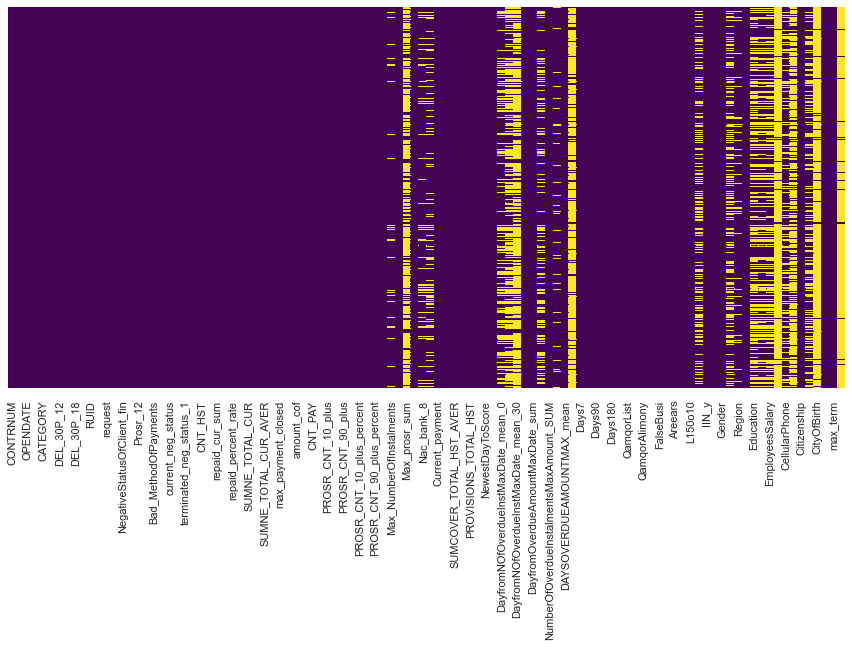

In [101]:
# посмотрим на все значения NAN
fig, ax = plt.subplots(figsize=(15,7))
sns_heatmap = sns.heatmap(df.sample(1000).isnull(), yticklabels=False, cbar=False, cmap='viridis')

как мы видим в датасете присутствует большое количество пропусков, посмотрим для начала все признаки: опишем их и посмотрим тип данных

In [141]:
columns = df.columns.tolist()
for i in columns:
    print (i, type(df[i][0]))

CONTRNUM <class 'str'>
IIN_x <class 'numpy.float64'>
OPENDATE <class 'pandas._libs.tslibs.timestamps.Timestamp'>
AMOUNTLOAN <class 'numpy.float64'>
CATEGORY <class 'str'>
PRODUCT <class 'str'>
DEL_30P_12 <class 'numpy.int64'>
DEL_90P_12 <class 'numpy.int64'>
DEL_30P_18 <class 'numpy.int64'>
DEL_90P_18 <class 'numpy.int64'>
RUID <class 'str'>
Unnamed: 0_y <class 'numpy.int64'>
request <class 'str'>
time1 <class 'datetime.datetime'>
NegativeStatusOfClient_fin <class 'numpy.int64'>
Prosr_3 <class 'numpy.int64'>
Prosr_12 <class 'numpy.int64'>
Prosr_36 <class 'numpy.int64'>
Bad_MethodOfPayments <class 'numpy.int64'>
ustupka <class 'numpy.int64'>
current_neg_status <class 'numpy.int64'>
terminated_neg_status <class 'numpy.int64'>
terminated_neg_status_1 <class 'numpy.int64'>
CNT_CUR <class 'numpy.int64'>
CNT_HST <class 'numpy.int64'>
repaid_count_rate <class 'numpy.float64'>
repaid_cur_sum <class 'numpy.float64'>
repaid_sum <class 'numpy.float64'>
repaid_percent_rate <class 'numpy.float64'>


### Описание полей датасета:

 - CONTRNUM - номер договора (Портфельные данные)
 - IIN_x - индивидуальный идентификационный код клиента (Портфельные данные)
 - OPENDATE - дата начала кредитногосоглашения (Портфельные данные)
 - AMOUNTLOAN - сумма по кредиту (Портфельные данные)
 - CATEGORY - категория кредитования (Портфельные данные)
 - PRODUCT - продукт кредитования (Портфельные данные)
 - DEL_90P_18  - целевая переменная (Портфельные данные)
 - RUID - RUID код клиента 
 - Unnamed: 0_y  - индексы при объединении файлов, нужно будет удалить
 - request -номер запроса (Кредитное бюро)
 - time1 - время запроса (Кредитное бюро)
 - NegativeStatusOfClient_fin - признак, имеет ли субъект негативный статус (Сгенер.признак))
 - Prosr_3 - просрочка более 10 000тг, более 10 дней за 3 мес по текущим кредитам (Сгенер.признак)
 - Prosr_12 - просрочка более 10 000тг, более 30 дней за 12 мес по всем кредитам (Сгенер.признак)
 - Prosr_36 - просрочка более 10 000тг, более 90 дней за 36 мес по всем кредитам (Сгенер.признак)
 - Bad_MethodOfPayments - плохие формы расчета (через страховые выплаты, выстреливание гарантии и тд) (Сгенер.признак) 
 - ustupka - уступка/переуступка прав требования по кредитному договору (Кредитное бюро)
 - current_neg_status - негативный статус хотя бы по одному из действующих договоров (Кредитное бюро)
 - terminated_neg_status - негативный статус хотя бы по одному из закрытых договоров до 60 мес (Сгенер.признак) 
 - terminated_neg_status_1 - если имеется проср. > 5 лет, то проверка на закрытый кредит после с проср. < 30 дн(Сгенер.признак) 
 - CNT_CUR - Количество текущих займов (Сгенер.признак)
 - CNT_HST - Количество закрытых займов (Сгенер.признак) 
 - repaid_count_rate - % закрытого количества кредитов от общего количества кредитов(Сгенер.признак) 
 - repaid_cur_sum - общая сумма выплаты по кредиту по действующим договорам (Сгенер.признак) 
 - repaid_sum - общая сумма выплаты по кредиту по всем договорам (Сгенер.признак) 
 - repaid_percent_rate - % закрытой суммы кредитов от общей суммы(Сгенер.признак) 
 - repaid_percent_rate_cur - % закрытой суммы кредитов от общей суммы по действующим (Сгенер.признак)
 - SUMNE_TOTAL_CUR - Сумма текущих займов (Сгенер.признак) 
 - SUMNE_TOTAL_HST - Сумма закрытых займов (Сгенер.признак) 
 - SUMNE_TOTAL_CUR_AVER - Средняя Сумма текущих займов (Если займов нет, то 0) (Сгенер.признак) 
 - SUMNE_TOTAL_HST_AVER - Средняя Сумма закрытых займов (Если займов нет, то 0) (Сгенер.признак)
 - max_payment_closed - максимальный одновременный платеж по закрытым займам (Сгенер.признак) 
 - max_payment_all - максимальный одновременный платеж по всем займам (Сгенер.признак) 
 - amount_cof - Соотношение средней суммы  текущих займов к закрытым (Сгенер.признак) 
 - PROSR_DAY_MAX - Максимальная просрочка за все время (Сгенер.признак) 
 - CNT_PAY - количество всех платежей (Сгенер.признак) 
 - PROSR_CNT - количество допущенных просрочек (Сгенер.признак) 
 - PROSR_CNT_10_plus - количество допущенных просрочек более 10 дней (Сгенер.признак) 
 - PROSR_CNT_30_plus - количество допущенных просрочек более 30 дней (Сгенер.признак) 
 - PROSR_CNT_90_plus - количество допущенных просрочек более 90 дней (Сгенер.признак) 
 - PROSR_CNT_percent - количество допущенных просрочек/количество всех платежей (Сгенер.признак) 
 - PROSR_CNT_10_plus_percent - количество допущенных просрочек более 10 дней/количество всех платежей (Сгенер.признак) 
 - PROSR_CNT_30_plus_percent - количество допущенных просрочек более 30 дней/количество всех платежей (Сгенер.признак) 
 - PROSR_CNT_90_plus_percent - количество допущенных просрочек более 90 дней/количество всех платежей (Сгенер.признак) 
 - mko_count - количество кредитов вязтых в микро-кредитных организациях
 - Max_NumberOfInstalments  - максимальное количество предстоящих платежей по кредитам (Сгенер.признак) 
 - credit_card_count - количество кредитных карт (Сгенер.признак)
 - Max_prosr_sum  - максимально просроченная сумма при просрочке более 30 дней (Сгенер.признак)
 - Payments_2_years - количество платежей в ближайшие 2 года
 - Nac_bank_8 - максимальная сумма по закрытым кредитам (признак для нац.банка)
 - Nac_bank_7 - максимальный ежемесячный платеж в ближайшие 3 года (признак для нац.банка)
 - Current_payment - максимальная сумма периодического платежа по действующим договорам (Сгенер.признак)
 - SUMCOVER_TOTAL_CUR_AVER - средняя сумма покрытия залогами по всем действующим договорам (Сгенер.признак)
 - SUMCOVER_TOTAL_HST_AVER - средняя сумма покрытия залогами по всем закрытым договорам (Сгенер.признак)
 - PROVISIONS_TOTAL_CUR  - общая сумма начисленных провизий по действующим договорам (Сгенер.признак)
 - PROVISIONS_TOTAL_HST - общая сумма начисленных провизий по закрытым договорам (Сгенер.признак)
 - OldestDayToScore - количесто дней с самой первой даты кредитования (Сгенер.признак)
 - NewestDayToScore - количесто дней с самой свежей даты кредитования (Сгенер.признак)
 - DayfromDateOFCreditStart_mean - среднее количесто дней с начала кредитования
 - DayfromNOfOverdueInstMaxDate_mean_0 - ср. кол-во дней с последней просрочки, если просрочка более 1 дня (Сгенер.признак)
 - DayfromNOfOverdueInstMaxDate_mean_10 - ср. кол-во дней с последней просрочки, если просрочка более 10 дней (Сгенер.признак) 
 - DayfromNOfOverdueInstMaxDate_mean_30 - ср. кол-во дней с последней просрочки, если просрочка более 30 дней (Сгенер.признак)
 - OverdueAmountMax_SUM - сумма максимальных просрочек (Сгенер.признак)  
 - DayfromOverdueAmountMaxDate_sum - сумма дней прошедших от максимальной задолженности (Сгенер.признак)
 - DayfromOverdueAmountMaxDate_mean - среднее количесто дней прошедших от максимальной задолженности (Сгенер.признак)
 - NumberOfOverdueInstalmentsMaxAmount_SUM - сумма задержек выплаты (Сгенер.признак)
 - ResidualAmount_mean - среднее значение остатков (Сгенер.признак)
 - DAYSOVERDUEAMOUNTMAX_mean - среднее значение максимальных просрочек (Сгенер.признак)
 - NegativeStatusOfClient - негативный статус клиента, мы создали признак, поэтому значения можно удалить (Кредитное бюро)
 - Days7  - количество запросов за 7 дней (Кредитное бюро)
 - Days30 - количество запросов за 30 дней (Кредитное бюро)
 - Days90 - количество запросов за 90 дней (Кредитное бюро)
 - Days120 - количество запросов за 120 дней (Кредитное бюро)
 - Days180 - количество запросов за 180 дней (Кредитное бюро)
 - Days360 - количество запросов за 360 дней (Кредитное бюро)
 - QamqorList - статус субъекта в списке розыска преступников, должников, без вести пропавших лиц (Кредитное бюро)
 - KgdWanted - статус субъекта в розыске Комитетом государственных доходов (Кредитное бюро)
 - QamqorAlimony - статус субъекта в розыске алиментщиков Комитетом по правовой статистике (Кредитное бюро)
 - RNUGosZakup - статус субъекта в рестре недобросовестных участников государственных закупок (Кредитное бюро)
 - FalseBusi - статус субъекта в перечне налогоплательщиков, осуществивших лжепредпринимательскую деятельность (Кредитное бюро)
 - TerrorList - статус субъекта в перечне организаций и лиц, связанных с финансированием терроризма (Кредитное бюро)
 - Areears - статус субъекта в списке плательщиков, имеющих задолженность по таможенным платежам (Кредитное бюро)
 - Bankruptcy - статус субъекта в списке несостоятельных должников/список банкротов (Кредитное бюро)
 - L150o10 - статус субъекта в списке налогоплательщиков - имеющих налоговую задолженность (Кредитное бюро)
 - Last_city - последний город проживания (Сгенер.признак)
 - IIN_y  - индивидуальный идентификационный код клиента (Кредитное бюро)
 - DateOfBirth - дата рождения субъекта (Кредитное бюро)
 - Gender  - пол субъекта (Кредитное бюро)
 - City - последний город при обновленных данных  (Кредитное бюро)
 - Region - регион при обновленных данных (Кредитное бюро)
 - NumberOfDependents - кол-во иждивенцев (Кредитное бюро)
 - Education  - уровень образования (Кредитное бюро)
 - MatrialStatus - семейное положение (Кредитное бюро)
 - EmployeesSalary - зарплата субъекта нетто (Кредитное бюро)
 - ZipCode - почтовый индекс субъекта (Кредитное бюро)
 - CellularPhone - мобильный номер субъекта (Кредитное бюро)
 - SubjectsEmployment - характер занятости клиента (Кредитное бюро)
 - Citizenship  - гражданство субъекта (Кредитное бюро)
 - EconomicActivityGroup - отрасль субъекта (Кредитное бюро)
 - CityOfBirth  - город рождения субъекта (Кредитное бюро)
 - Age  - возраст субъекта (Кредитное бюро)
 - max_term - расчет максимального срока кредита (до пенс.возраста) (Сгенер.признак)
 - error_text- вывод ошибки при отсутствии субъекта в кредитном бюро (Кредитное бюро)

In [142]:
# изменим имена всех столбцов ( все буквы маленькие)
df.columns = df.columns.str.lower()

In [143]:
# удалим сразу лишние признаки, и создадим одну целевую переменную:
df['Default']= df['del_90p_18'].apply(lambda x: 0 if x == 0 else 1)
#df['Default']= df['del_90p_12'].apply(lambda x: 0 if x == 0 else 1)

df = df.drop(columns = ['del_30p_12','del_90p_12','del_30p_18','del_90p_18'])

In [144]:
# удаляем эти признаки тк в них нет необходимости, как писала выше
df = df.drop(columns = ['unnamed: 0_y','negativestatusofclient'])

In [221]:
df.dtypes.value_counts()

int32     68
int64     13
object     8
dtype: int64

числовых признаков у нас 81, объектов типа object - 21 и одна колонка с типом дата/время. начнем с обработки полей типа object, больше всего пропусков в значениях ошибках, городе рождения, негативном статусе клиента и характере занятости. рассмотрим все поля подробнее.

In [220]:
df.select_dtypes(include = ['object']).isna().sum().sort_values(ascending=False)

error_text            0
citizenship           0
subjectsemployment    0
employeessalary       0
matrialstatus         0
education             0
gender                0
category              0
dtype: int64

сначала пройдемся по всем городам (город рождения, город проживания, последние введенные данные по городу) во всех трех признаках имеются пропуски, оставим их без изменения, а также оставим основные города страны в виде циферного значения, а все остальное отнесем к прочим

In [147]:
for i in ['cityofbirth','city','last_city']:
    CityExtract(i)

заполним все пустые ячейки 0, тк вполне возможно что субъект не предоставил ту или иную информацию о себе

In [148]:
obj_columns = df.select_dtypes(include = ['object']).columns
for i in obj_columns:
    df[i].fillna(0, inplace=True)

 - удалим признак "iin_y", но прежде заполним пустые значения признака "iin_x" значением из "iin_y"
 - удалим продукт, тк в нем у нас только одно значение
 - удалим time1
 - также считаю что регион проживания тоже не несет в себе информации, тк мы имеем более точную информацию по городам


In [149]:
df.iin_x = df.iin_x.fillna(df.iin_y)

In [150]:
df = df.drop(columns = ['iin_y','product','time1','region'])

тк номер мобильного номера нам особо не поможет, просто определим есть номер или нет, создав тем самым бинарный признак

In [151]:
df['cellularphone']= df['cellularphone'].apply(lambda x: 1 if (len(str(x))>=10 and x!='отсутствует') else 0)

In [152]:
df = df.apply(DateOfBirthCorr, axis=1)

In [153]:
# в целом мы уже имеем признак возраст, думаю дату рождения все-таки можно удалить, 
# также удалим ruid он не несет в себе никакой информации
# удалим номер договора
# удалим номер запроса, думаю он не несет в себе информацию
df = df.drop(columns = ['ruid','contrnum','dateofbirth','request'])

In [154]:
# все признаки с типом object можно отнести к категориальным
cat_features = df.select_dtypes(include = ['object']).columns.tolist()
cat_features

['category',
 'gender',
 'education',
 'matrialstatus',
 'employeessalary',
 'subjectsemployment',
 'citizenship',
 'economicactivitygroup',
 'error_text']

In [155]:
#увеличим список категориальных признаков, тк данные колонки имеют не являются числовыми
cat_not_num = ['l150o10','bankruptcy','areears','terrorlist','falsebusi','rnugoszakup',\
 'qamqoralimony','kgdwanted','qamqorlist','cellularphone',\
'negativestatusofclient_fin','bad_methodofpayments','Default']
cat_features.extend(cat_not_num)

In [156]:
cat_features

['category',
 'gender',
 'education',
 'matrialstatus',
 'employeessalary',
 'subjectsemployment',
 'citizenship',
 'economicactivitygroup',
 'error_text',
 'l150o10',
 'bankruptcy',
 'areears',
 'terrorlist',
 'falsebusi',
 'rnugoszakup',
 'qamqoralimony',
 'kgdwanted',
 'qamqorlist',
 'cellularphone',
 'negativestatusofclient_fin',
 'bad_methodofpayments',
 'Default']

In [219]:
df.select_dtypes(include = ['int64']).isna().sum().sort_values(ascending=False)

Default                       0
cellularphone                 0
l150o10                       0
bankruptcy                    0
areears                       0
terrorlist                    0
falsebusi                     0
rnugoszakup                   0
qamqoralimony                 0
kgdwanted                     0
qamqorlist                    0
bad_methodofpayments          0
negativestatusofclient_fin    0
dtype: int64

In [158]:
# все признаки с типом int64 можно отнести к числовым, за исключением тех что мы отнесли к категориальным
num_features = df.select_dtypes(include = ['int64']).columns.tolist()
for i in cat_not_num:
    num_features.remove(i)
len(num_features)

31

In [218]:
df.select_dtypes(include = ['float64']).isna().sum().sort_values(ascending=False)

Series([], dtype: float64)

- посмотрим теперь на признаки в формате float64, их у нас 36. очень много пропусков в zipcode,
- тк у нас имеется имнформация по городам, думаю этот признак можно будет удалить. 
- те признаки что у нас категориальнве, относим к категориальным, остальное в числовые.
- заполним пустые значения 0 и все цифровые признаки отнесем к num_features


In [160]:
#увеличим список категориальных признаков, тк данные колонки имеют не являются числовыми
cat_not_float = ['last_city','city','iin_x','cityofbirth']
cat_features.extend(cat_not_float)

In [161]:
df = df.drop(columns = ['zipcode'])

In [162]:
#тк процентные ставки при переходе на инт станут 0/1, переведем их в процентное соотношение
rates = ['repaid_percent_rate_cur','prosr_cnt_percent','repaid_percent_rate',\
         'repaid_count_rate','prosr_cnt_10_plus_percent','prosr_cnt_30_plus_percent',\
         'prosr_cnt_90_plus_percent']
for i in rates:
    df[i] = df[i]*100

In [214]:
np.isfinite(df.select_dtypes(include = ['float64'])).sum().sort_values(ascending=False)

max_term                                   189670
prosr_cnt_30_plus                          189670
payments_2_years                           189670
max_prosr_sum                              189670
credit_card_count                          189670
max_numberofinstalments                    189670
mko_count                                  189670
prosr_cnt_90_plus_percent                  189670
prosr_cnt_30_plus_percent                  189670
prosr_cnt_10_plus_percent                  189670
prosr_cnt_percent                          189670
prosr_cnt_90_plus                          189670
prosr_cnt_10_plus                          189670
age                                        189670
prosr_cnt                                  189670
cnt_pay                                    189670
prosr_day_max                              189670
amount_cof                                 189670
max_payment_all                            189670
max_payment_closed                         189670


In [215]:
# здесь нужно еще подумать
float_columns = df.select_dtypes(include = ['float64']).columns
for i in float_columns:
    df[i] = df[i].replace([np.inf, -np.inf], 1)

In [216]:
float_columns = df.select_dtypes(include = ['float64']).columns
for i in float_columns:
    df[i] = df[i].astype(int)

In [188]:
float_columns = df.select_dtypes(include = ['float64']).columns
for i in float_columns:
    df[i].fillna(0, inplace=True)

In [164]:
float_features = df.select_dtypes(include = ['float64']).columns.tolist()
for i in cat_not_float:
    float_features.remove(i)
num_features.extend(float_features)

In [165]:
for i in cat_not_float:
    df[i] = df[i].astype(int)

In [166]:
df[num_features].describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
prosr_3,189670.0,0.002362,7.591024e-02,0.0,0.0,0.00,0.000,6.000000e+00
prosr_12,189670.0,0.008467,3.404700e-01,0.0,0.0,0.00,0.000,7.700000e+01
prosr_36,189670.0,0.016086,9.966700e-01,0.0,0.0,0.00,0.000,2.640000e+02
ustupka,189670.0,0.116181,3.743502e-01,0.0,0.0,0.00,0.000,1.100000e+01
current_neg_status,189670.0,0.003975,6.729752e-02,0.0,0.0,0.00,0.000,3.000000e+00
...,...,...,...,...,...,...,...,...
overdueamountmax_sum,189670.0,148248.142215,5.428947e+06,0.0,0.0,22665.70,84362.280,1.495448e+09
dayfromoverdueamountmaxdate_mean,189670.0,951.615458,1.025392e+03,-303.0,0.0,707.50,1580.000,5.339000e+03
numberofoverdueinstalmentsmaxamount_sum,189670.0,105599.660810,4.855406e+06,0.0,0.0,15187.77,62782.375,1.495343e+09
residualamount_mean,189670.0,97727.597403,2.106719e+05,0.0,0.0,10688.00,111826.700,3.816390e+07


In [167]:
# дата начала кредитного соглашения у нас и так имеется при генерации фичей, этот признак можно бдует удалить
df = df.drop(columns = df.select_dtypes(include = ['datetime64[ns]']).columns)

с предобработкой закончили, теперь посмотрим на признаки более внимательно и возможно удалим лишнее

### разведовательный анализ данных

начнем с категориальных признаков, среди них имеется целевая переменна исключим ее

In [168]:
cat_features.remove('Default')

In [169]:
cat_features

['category',
 'gender',
 'education',
 'matrialstatus',
 'employeessalary',
 'subjectsemployment',
 'citizenship',
 'economicactivitygroup',
 'error_text',
 'l150o10',
 'bankruptcy',
 'areears',
 'terrorlist',
 'falsebusi',
 'rnugoszakup',
 'qamqoralimony',
 'kgdwanted',
 'qamqorlist',
 'cellularphone',
 'negativestatusofclient_fin',
 'bad_methodofpayments',
 'last_city',
 'city',
 'iin_x',
 'cityofbirth']

In [170]:
#посмотрим на дефолты в разрезе категорий 
def_categ = df.groupby(['category', 'Default'], dropna=False)['category'].count().unstack().fillna(0).unstack().reset_index()

Text(0.5, 1.0, 'Распределение дефолта в разрезе категорий')

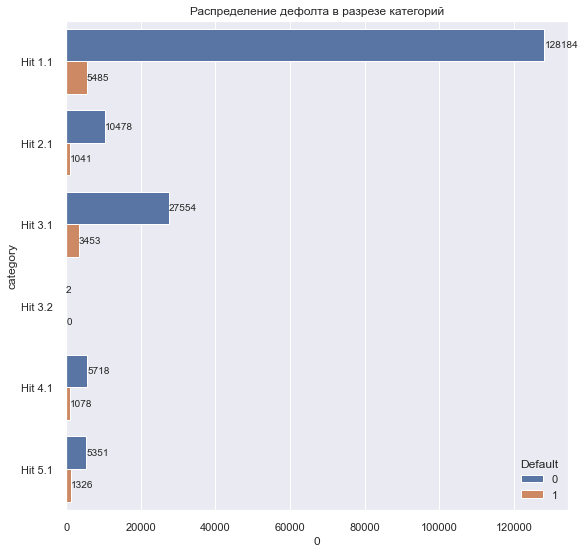

In [171]:
plt.rcParams['figure.figsize']=9,9
ax = sns.barplot(x=0, y='category', hue='Default', data=def_categ)
ShowValuesOnBars(ax, 'h', 8)
plt.title('Распределение дефолта в разрезе категорий')
plt.show()

наблюдаем градиентное увеличение количества дефолтных клиентов от хит1 к хит5

In [174]:
#посмотрим на дефолты в разрезе категорий 
def_salary = df.groupby(['employeessalary', 'Default'], dropna=False)['employeessalary'].count().unstack().fillna(0).unstack().reset_index()

Text(0.5, 1.0, 'Распределение дефолта в разрезе заработной платы')

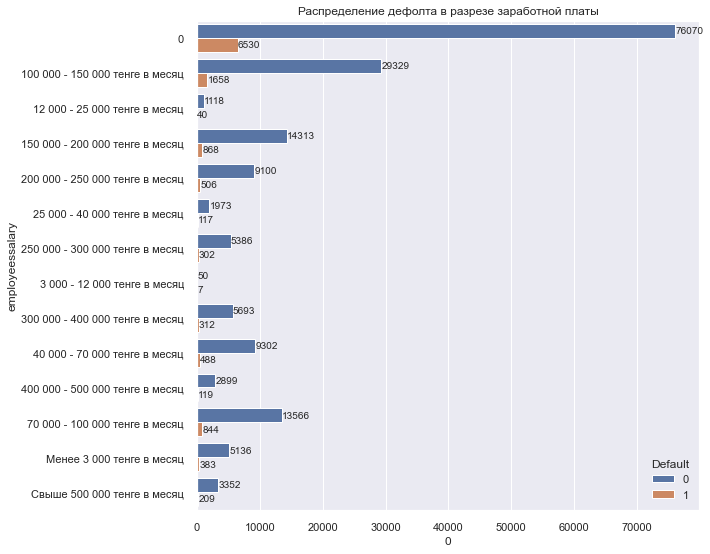

In [175]:
plt.rcParams['figure.figsize']=9,9
ax = sns.barplot(x=0, y='employeessalary', hue='Default', data=def_salary)
ShowValuesOnBars(ax, 'h', 8)
plt.title('Распределение дефолта в разрезе заработной платы')
plt.show()

большое количество дефолтов у клиентов не имеющих кредитной истории, в целом распределение равномерное

Количество пропусков: 0,
count    189670.000000
mean          0.002362
std           0.075910
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           6.000000
Name: prosr_3, dtype: float64,
Распределение:
0    189444
1        84
2        75
3        60
4         3
6         2
5         2
Name: prosr_3, dtype: int64,
Количество пропусков: 0,
count    189670.000000
mean          0.008467
std           0.340470
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          77.000000
Name: prosr_12, dtype: float64,
Распределение:
0     189374
1         71
2         54
4         27
12        24
6         20
3         19
7         16
11        15
5         13
9         12
10        10
8          8
14         2
48         1
17         1
26         1
44         1
77         1
Name: prosr_12, dtype: int64,
Количество пропусков: 0,
count    189670.000000
mean          0.016086
std           0.996670
min  

Количество пропусков: 0,
count    189670.000000
mean       2770.370491
std        1691.178091
min        -312.000000
25%        1367.000000
50%        2662.500000
75%        4423.000000
max        7718.000000
Name: oldestdaytoscore, dtype: float64,
Распределение:
0       7891
4585      86
4696      86
4410      81
4634      80
        ... 
6789       1
6875       1
6035       1
5702       1
5960       1
Name: oldestdaytoscore, Length: 6451, dtype: int64,
Количество пропусков: 0,
count    189670.000000
mean        341.918669
std         539.767332
min        -463.000000
25%          56.000000
50%         178.000000
75%         395.000000
max        7223.000000
Name: newestdaytoscore, dtype: float64,
Распределение:
0       8038
56       590
28       548
84       528
49       522
        ... 
3420       1
3164       1
3036       1
2908       1
3361       1
Name: newestdaytoscore, Length: 4107, dtype: int64,
Количество пропусков: 0,
count    189670.000000
mean       1420.506590
std        

Распределение:
 0.00          76520
-570.00           19
 1000000.00       15
 200000.00        14
 1500000.00       10
               ...  
 1437581.79        1
 91331.67          1
 495349.29         1
 29289.12          1
 41514.17          1
Name: repaid_cur_sum, Length: 112341, dtype: int64,
Количество пропусков: 0,
count    1.896700e+05
mean     3.086764e+06
std      1.835569e+07
min     -1.298885e+07
25%      2.420172e+05
50%      1.202109e+06
75%      3.323946e+06
max      5.713267e+09
Name: repaid_sum, dtype: float64,
Распределение:
0.00          22505
1000000.00      259
500000.00       239
300000.00       237
200000.00       237
              ...  
2801743.28        1
174323.00         1
2982201.44        1
2404023.00        1
1175162.23        1
Name: repaid_sum, Length: 158173, dtype: int64,
Количество пропусков: 0,
count    189670.000000
mean         68.423530
std          34.769163
min         -60.000000
25%          49.953134
50%          80.495693
75%         100.00000

Количество пропусков: 0,
count    1.896700e+05
mean     2.801799e+05
std      3.198453e+06
min      0.000000e+00
25%      0.000000e+00
50%      3.912787e+04
75%      1.423875e+05
max      1.053500e+09
Name: nac_bank_7, dtype: float64,
Распределение:
0.00         48235
5000.00        689
10000.00       638
15000.00       269
25000.00       265
             ...  
71660.00         1
14949.00         1
150102.00        1
102032.96        1
28668.00         1
Name: nac_bank_7, Length: 116123, dtype: int64,
Количество пропусков: 0,
count    1.896700e+05
mean     7.363814e+04
std      1.059688e+06
min      0.000000e+00
25%      0.000000e+00
50%      3.277340e+04
75%      8.898680e+04
max      2.987664e+08
Name: current_payment, dtype: float64,
Распределение:
0.000000        74875
41666.666667       51
25000.000000       42
50000.000000       41
83333.333333       38
                ...  
86386.890000        1
99951.450000        1
59909.000000        1
65338.920000        1
33683.960000      

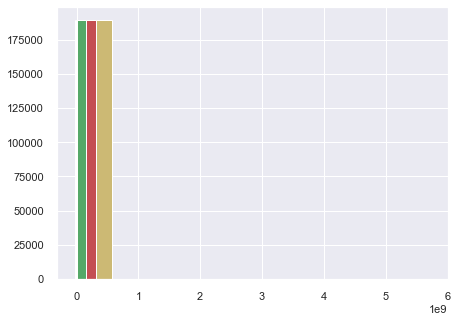

In [173]:
for i in num_features:
    ColInfo(df[i])

In [43]:
for i in num_features:
    print('Переменная: '+i+', количество выбросов:', len(sp.outliers_iqr(df[i], ret = 'outliers')))

Переменная: unnamed: 0_y, количество выбросов: 0
Переменная: prosr_3, количество выбросов: 226
Переменная: prosr_12, количество выбросов: 296
Переменная: prosr_36, количество выбросов: 236
Переменная: ustupka, количество выбросов: 19035
Переменная: current_neg_status, количество выбросов: 705
Переменная: terminated_neg_status, количество выбросов: 51
Переменная: terminated_neg_status_1, количество выбросов: 3384
Переменная: cnt_cur, количество выбросов: 13946
Переменная: cnt_hst, количество выбросов: 7801
Переменная: prosr_day_max, количество выбросов: 25831
Переменная: cnt_pay, количество выбросов: 5200
Переменная: prosr_cnt, количество выбросов: 17450
Переменная: prosr_cnt_10_plus, количество выбросов: 17450
Переменная: prosr_cnt_30_plus, количество выбросов: 42045
Переменная: prosr_cnt_90_plus, количество выбросов: 21716
Переменная: mko_count, количество выбросов: 17707
Переменная: credit_card_count, количество выбросов: 4392
Переменная: payments_2_years, количество выбросов: 4001
П

In [178]:
for i in num_features:
    Log(i)

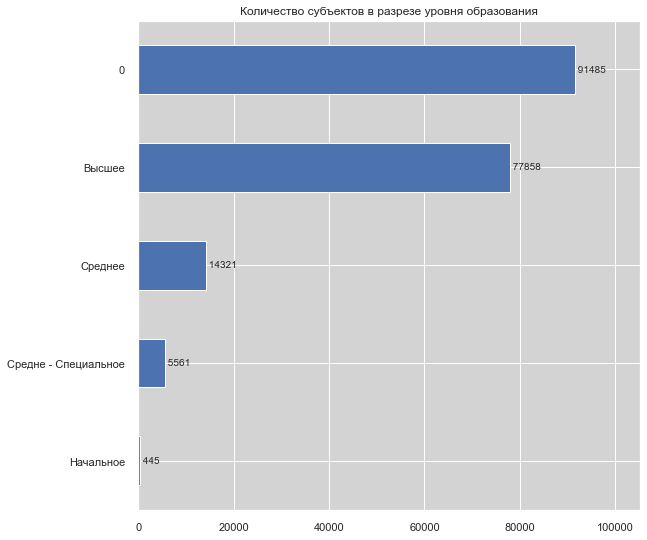

In [179]:
VizCounterBar(df,'education','Количество субъектов в разрезе уровня образования')

In [49]:
#sns.kdeplot(df.loc[df['Default'] == 1, 'age'], label = 'default')
#sns.kdeplot(df.loc[df['Default'] == 0, 'age'], label = 'nondefault')

#plt.title('Распределение возраста заемщиков');

### корреляционный анализ переменных

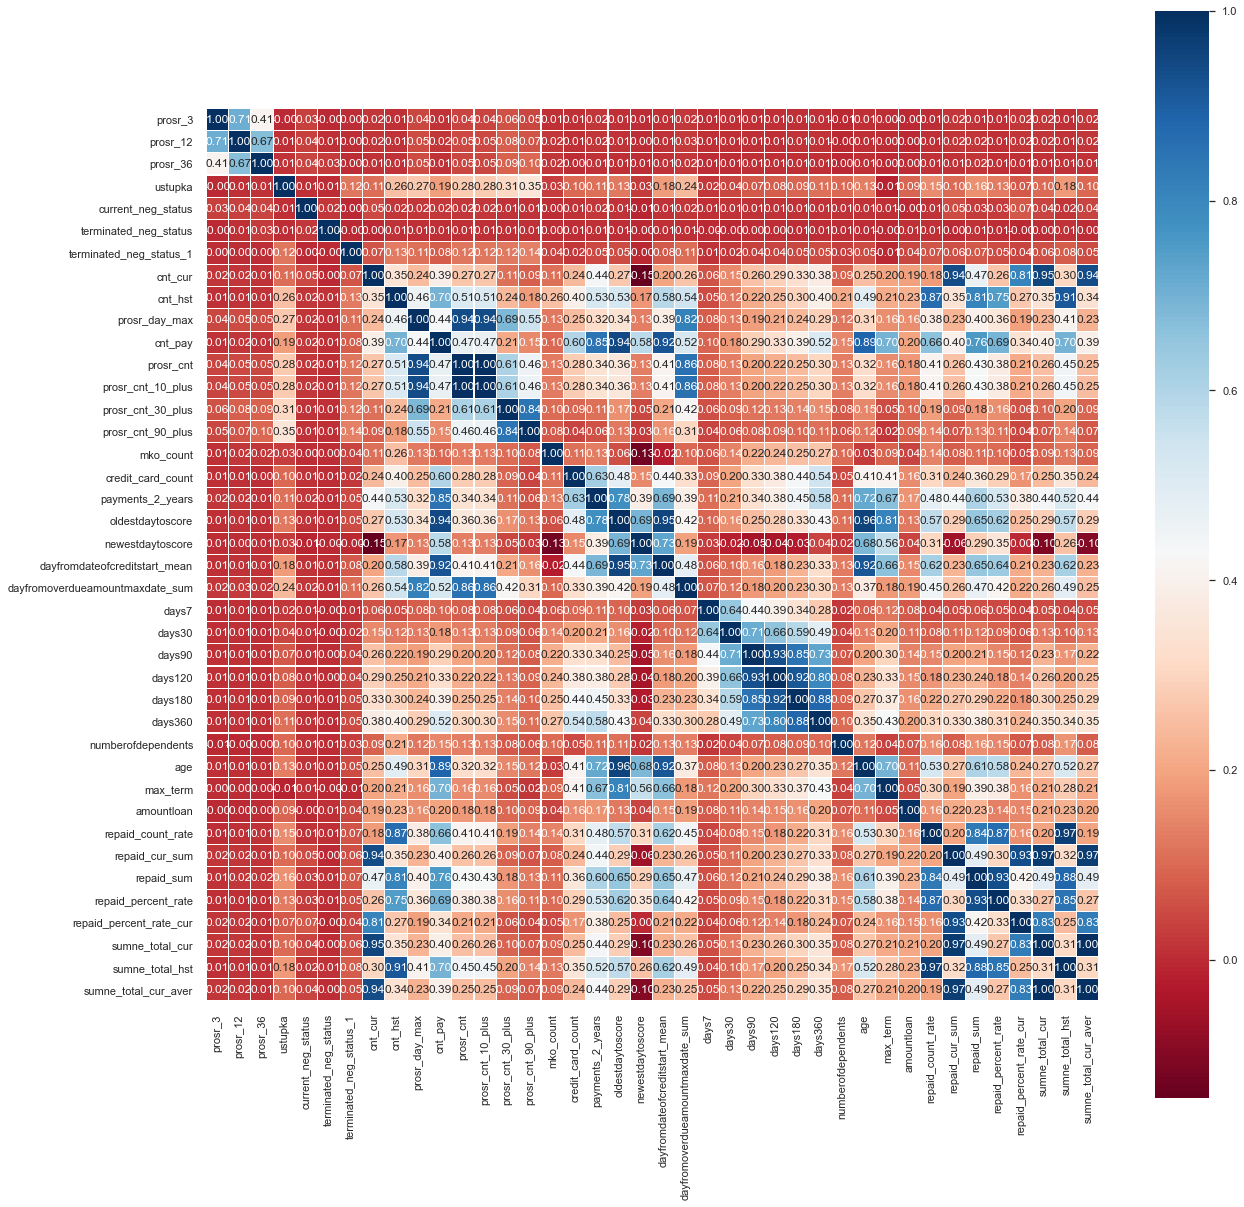

In [181]:
# теперь посмотрим на корреляцию числовых признаков между собой
sns.set (font_scale=1)
plt.subplots (figsize=(20,20))
sns.heatmap(df[num_features[0:40]].corr(), square=True, annot=True, fmt=".2f", linewidths=0.1, cmap="RdBu");

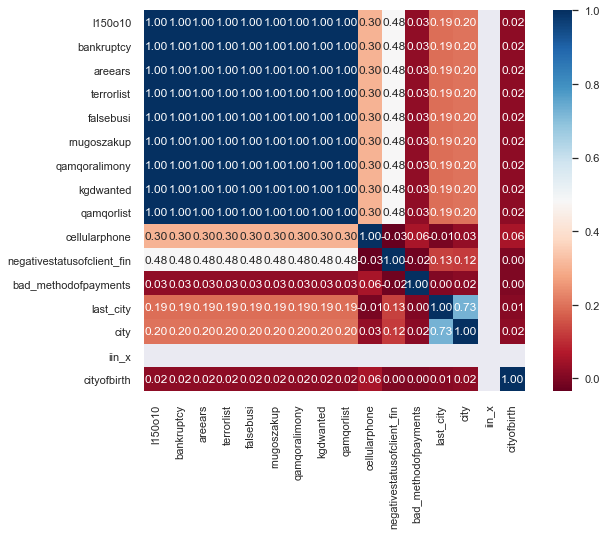

In [182]:
# теперь посмотрим на корреляцию категориальных признаков между собой
sns.set (font_scale=1)
plt.subplots (figsize=(10,7))
sns.heatmap(df[cat_features].corr(), square=True, annot=True, fmt=".2f", cmap="RdBu");

In [183]:
df = df.drop(columns = ['city', 'economicactivitygroup'])

In [184]:
cat_features.remove('city')
cat_features.remove('economicactivitygroup')

### подготовка данных к машинному обучению

In [54]:
# для категориальных признаков мы будем использовать OneHotEncoder
df=pd.get_dummies(df, prefix=cat_features, columns=cat_features)

In [55]:
# cтандартизация
df[num_features] = StandardScaler().fit_transform(df[num_features].values)
#df[num_features] = MinMaxScaler().fit_transform(df[num_features].values)

In [190]:
df.select_dtypes(include = ['float64']).isna().sum().sort_values(ascending=False)

max_term                                   0
age                                        0
payments_2_years                           0
max_prosr_sum                              0
credit_card_count                          0
max_numberofinstalments                    0
mko_count                                  0
prosr_cnt_90_plus_percent                  0
prosr_cnt_30_plus_percent                  0
prosr_cnt_10_plus_percent                  0
prosr_cnt_percent                          0
prosr_cnt_90_plus                          0
prosr_cnt_30_plus                          0
prosr_cnt_10_plus                          0
prosr_cnt                                  0
cnt_pay                                    0
prosr_day_max                              0
amount_cof                                 0
max_payment_all                            0
max_payment_closed                         0
sumne_total_hst_aver                       0
sumne_total_cur_aver                       0
sumne_tota

In [58]:
# значимость категориальных и бинарных переменных
all_cols = list(df.columns)
all_num_cols = num_features
target_col = ['Default']
all_cat = [x for x in all_cols if x not in (all_num_cols+target_col)]

temp_df = df
imp_cat = pd.Series(mutual_info_classif(temp_df[all_cat], temp_df['Default'], discrete_features =True), index = all_cat)
imp_cat.sort_values(inplace = True)
imp_cat.iplot(kind = 'barh')

In [223]:
X = df.drop(['Default'], axis=1)
y = df.Default.values
X.shape

(189670, 88)

In [224]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=47)

### обучаем разные модели и смотрим на результат

In [61]:
# LogisticRegression:
alg_log = LogisticRegression(random_state=47, max_iter=200)
alg_log.fit(X_train, y_train)
scores = cross_val_score(alg_log, X_test, y_test, cv=5, scoring='roc_auc', n_jobs=-1)
print("roc_auc (logistic regression): {}/{}".format(scores.mean(), scores.std()))

C:\Users\aabdraimova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression(max_iter=200, random_state=47)

roc_auc (logistic regression): 0.7571731512621147/0.008769474308001925


In [62]:
# KNeighborsClassifier:
alg_ngbh = KNeighborsClassifier(n_neighbors=3)
alg_ngbh.fit(X_train, y_train)
scores = cross_val_score(alg_ngbh, X_test, y_test, cv=5, scoring='roc_auc', n_jobs=-1)
print("roc_auc (k-neighbors): {}/{}".format(scores.mean(), scores.std()))

KNeighborsClassifier(n_neighbors=3)

roc_auc (k-neighbors): 0.5697235335942796/0.01032662529055392


In [63]:
# RandomForestClassifier:
alg_frst = RandomForestClassifier(random_state=47, n_estimators=500, min_samples_split=8, min_samples_leaf=2)
alg_frst.fit(X_train, y_train)
scores = cross_val_score(alg_frst, X_test, y_test, cv=5, scoring='roc_auc', n_jobs=-1)
print("roc_auc (random forest): {}/{}".format(scores.mean(), scores.std()))

RandomForestClassifier(min_samples_leaf=2, min_samples_split=8,
                       n_estimators=500, random_state=47)

roc_auc (random forest): 0.7557307417301236/0.012466629223990855


In [64]:
# GradientBoostingClassifier:
alg_gb = GradientBoostingClassifier(random_state=47)
alg_gb.fit(X_train, y_train)
scores = cross_val_score(alg_gb, X_test, y_test, cv=5, scoring='roc_auc', n_jobs=-1)
print("roc_auc (gradient boosting): {}/{}".format(scores.mean(), scores.std()))

GradientBoostingClassifier(random_state=47)

roc_auc (gradient boosting): 0.7613443903864299/0.012724569400592706


In [202]:
# CatBoostingRegressor:
cat_feat=X.columns
cat_feat

Index(['iin_x', 'amountloan', 'category', 'negativestatusofclient_fin',
       'prosr_3', 'prosr_12', 'prosr_36', 'bad_methodofpayments', 'ustupka',
       'current_neg_status', 'terminated_neg_status',
       'terminated_neg_status_1', 'cnt_cur', 'cnt_hst', 'repaid_count_rate',
       'repaid_cur_sum', 'repaid_sum', 'repaid_percent_rate',
       'repaid_percent_rate_cur', 'sumne_total_cur', 'sumne_total_hst',
       'sumne_total_cur_aver', 'sumne_total_hst_aver', 'max_payment_closed',
       'max_payment_all', 'amount_cof', 'prosr_day_max', 'cnt_pay',
       'prosr_cnt', 'prosr_cnt_10_plus', 'prosr_cnt_30_plus',
       'prosr_cnt_90_plus', 'prosr_cnt_percent', 'prosr_cnt_10_plus_percent',
       'prosr_cnt_30_plus_percent', 'prosr_cnt_90_plus_percent', 'mko_count',
       'max_numberofinstalments', 'credit_card_count', 'max_prosr_sum',
       'payments_2_years', 'nac_bank_8', 'nac_bank_7', 'current_payment',
       'sumcover_total_cur_aver', 'sumcover_total_hst_aver',
       'provisio

In [66]:
from catboost import Pool
import sklearn.metrics
def objective(trial):
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.8, random_state=47)
    train_pool = Pool(train_x, train_y, cat_features=cat_feat)
    test_pool = Pool(test_x, test_y, cat_features=cat_feat)

    params = {
        'iterations' : trial.suggest_int('iterations', 50, 980),                         
        'depth' : trial.suggest_int('depth', 4, 10),                                       
        'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),               
        'random_strength' :trial.suggest_int('random_strength', 0, 100),                       
        'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00), 
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        'od_wait' :trial.suggest_int('od_wait', 10, 50)
    }

    model = CatBoostRegressor(**params)
    model.fit(train_pool)
    preds = model.predict(test_pool)
    pred_labels = np.rint(preds)
    ROCAUC = sklearn.metrics.roc_auc_score(test_y, pred_labels)
    return ROCAUC

In [67]:
# подбор гиперпараметров
#if __name__ == '__main__':
#    study = optuna.create_study()
#    study.optimize(objective, n_trials=3)
    #print(study.best_trial)
#study.best_params
#optuna.visualization.plot_slice(study)

[I 2021-06-03 00:01:45,389] A new study created in memory with name: no-name-fe11dda3-d485-4418-8912-ad9414f55163


0:	learn: 0.2472340	total: 171ms	remaining: 2m 39s
1:	learn: 0.2472340	total: 235ms	remaining: 1m 49s
2:	learn: 0.2463063	total: 603ms	remaining: 3m 6s
3:	learn: 0.2457528	total: 855ms	remaining: 3m 18s
4:	learn: 0.2449423	total: 1.41s	remaining: 4m 21s
5:	learn: 0.2449423	total: 1.45s	remaining: 3m 44s
6:	learn: 0.2444866	total: 1.98s	remaining: 4m 21s
7:	learn: 0.2442458	total: 2.43s	remaining: 4m 41s
8:	learn: 0.2440694	total: 2.83s	remaining: 4m 50s
9:	learn: 0.2438075	total: 3.18s	remaining: 4m 53s
10:	learn: 0.2438075	total: 3.22s	remaining: 4m 29s
11:	learn: 0.2438075	total: 3.25s	remaining: 4m 9s
12:	learn: 0.2438075	total: 3.28s	remaining: 3m 52s
13:	learn: 0.2429283	total: 3.82s	remaining: 4m 10s
14:	learn: 0.2424404	total: 4.39s	remaining: 4m 28s
15:	learn: 0.2418911	total: 4.62s	remaining: 4m 24s
16:	learn: 0.2418911	total: 4.65s	remaining: 4m 10s
17:	learn: 0.2415222	total: 5.22s	remaining: 4m 25s
18:	learn: 0.2413887	total: 5.46s	remaining: 4m 22s
19:	learn: 0.2413879	tot

158:	learn: 0.2298987	total: 1m 7s	remaining: 5m 30s
159:	learn: 0.2298568	total: 1m 8s	remaining: 5m 30s
160:	learn: 0.2297811	total: 1m 8s	remaining: 5m 30s
161:	learn: 0.2297476	total: 1m 9s	remaining: 5m 30s
162:	learn: 0.2297404	total: 1m 10s	remaining: 5m 30s
163:	learn: 0.2296796	total: 1m 10s	remaining: 5m 30s
164:	learn: 0.2295936	total: 1m 11s	remaining: 5m 31s
165:	learn: 0.2295139	total: 1m 11s	remaining: 5m 31s
166:	learn: 0.2294641	total: 1m 12s	remaining: 5m 31s
167:	learn: 0.2294331	total: 1m 12s	remaining: 5m 30s
168:	learn: 0.2294093	total: 1m 13s	remaining: 5m 30s
169:	learn: 0.2293482	total: 1m 13s	remaining: 5m 30s
170:	learn: 0.2293024	total: 1m 14s	remaining: 5m 30s
171:	learn: 0.2292372	total: 1m 14s	remaining: 5m 30s
172:	learn: 0.2291944	total: 1m 15s	remaining: 5m 30s
173:	learn: 0.2290043	total: 1m 15s	remaining: 5m 31s
174:	learn: 0.2289105	total: 1m 16s	remaining: 5m 32s
175:	learn: 0.2288950	total: 1m 17s	remaining: 5m 32s
176:	learn: 0.2288413	total: 1m 

311:	learn: 0.2236309	total: 2m 29s	remaining: 4m 57s
312:	learn: 0.2235931	total: 2m 30s	remaining: 4m 57s
313:	learn: 0.2235789	total: 2m 30s	remaining: 4m 57s
314:	learn: 0.2235597	total: 2m 31s	remaining: 4m 56s
315:	learn: 0.2235052	total: 2m 31s	remaining: 4m 56s
316:	learn: 0.2234158	total: 2m 32s	remaining: 4m 55s
317:	learn: 0.2234016	total: 2m 32s	remaining: 4m 55s
318:	learn: 0.2233761	total: 2m 33s	remaining: 4m 54s
319:	learn: 0.2233498	total: 2m 33s	remaining: 4m 54s
320:	learn: 0.2232930	total: 2m 33s	remaining: 4m 53s
321:	learn: 0.2232700	total: 2m 34s	remaining: 4m 53s
322:	learn: 0.2232101	total: 2m 35s	remaining: 4m 52s
323:	learn: 0.2232083	total: 2m 35s	remaining: 4m 52s
324:	learn: 0.2231763	total: 2m 36s	remaining: 4m 52s
325:	learn: 0.2231480	total: 2m 36s	remaining: 4m 52s
326:	learn: 0.2231296	total: 2m 37s	remaining: 4m 52s
327:	learn: 0.2231181	total: 2m 38s	remaining: 4m 51s
328:	learn: 0.2231081	total: 2m 38s	remaining: 4m 51s
329:	learn: 0.2230915	total:

464:	learn: 0.2196505	total: 3m 59s	remaining: 4m
465:	learn: 0.2196440	total: 3m 59s	remaining: 4m
466:	learn: 0.2196404	total: 4m	remaining: 3m 59s
467:	learn: 0.2195868	total: 4m	remaining: 3m 59s
468:	learn: 0.2195506	total: 4m 1s	remaining: 3m 58s
469:	learn: 0.2195460	total: 4m 2s	remaining: 3m 58s
470:	learn: 0.2195436	total: 4m 2s	remaining: 3m 58s
471:	learn: 0.2195168	total: 4m 3s	remaining: 3m 57s
472:	learn: 0.2194887	total: 4m 4s	remaining: 3m 57s
473:	learn: 0.2194523	total: 4m 4s	remaining: 3m 57s
474:	learn: 0.2194222	total: 4m 5s	remaining: 3m 56s
475:	learn: 0.2194060	total: 4m 6s	remaining: 3m 56s
476:	learn: 0.2193998	total: 4m 6s	remaining: 3m 56s
477:	learn: 0.2193735	total: 4m 7s	remaining: 3m 55s
478:	learn: 0.2193625	total: 4m 8s	remaining: 3m 55s
479:	learn: 0.2193564	total: 4m 8s	remaining: 3m 54s
480:	learn: 0.2193395	total: 4m 9s	remaining: 3m 54s
481:	learn: 0.2193189	total: 4m 9s	remaining: 3m 53s
482:	learn: 0.2193068	total: 4m 10s	remaining: 3m 53s
483:

618:	learn: 0.2160839	total: 5m 40s	remaining: 2m 52s
619:	learn: 0.2160511	total: 5m 41s	remaining: 2m 52s
620:	learn: 0.2159966	total: 5m 41s	remaining: 2m 51s
621:	learn: 0.2159773	total: 5m 42s	remaining: 2m 51s
622:	learn: 0.2159563	total: 5m 42s	remaining: 2m 50s
623:	learn: 0.2159228	total: 5m 43s	remaining: 2m 50s
624:	learn: 0.2159095	total: 5m 44s	remaining: 2m 49s
625:	learn: 0.2158344	total: 5m 44s	remaining: 2m 49s
626:	learn: 0.2158126	total: 5m 45s	remaining: 2m 48s
627:	learn: 0.2158040	total: 5m 46s	remaining: 2m 48s
628:	learn: 0.2157969	total: 5m 47s	remaining: 2m 47s
629:	learn: 0.2157908	total: 5m 48s	remaining: 2m 47s
630:	learn: 0.2157784	total: 5m 48s	remaining: 2m 46s
631:	learn: 0.2157419	total: 5m 49s	remaining: 2m 46s
632:	learn: 0.2156770	total: 5m 50s	remaining: 2m 46s
633:	learn: 0.2156124	total: 5m 51s	remaining: 2m 45s
634:	learn: 0.2155972	total: 5m 51s	remaining: 2m 45s
635:	learn: 0.2155550	total: 5m 52s	remaining: 2m 44s
636:	learn: 0.2155128	total:

771:	learn: 0.2130691	total: 7m 26s	remaining: 1m 33s
772:	learn: 0.2130383	total: 7m 26s	remaining: 1m 32s
773:	learn: 0.2130243	total: 7m 27s	remaining: 1m 31s
774:	learn: 0.2130222	total: 7m 28s	remaining: 1m 31s
775:	learn: 0.2130142	total: 7m 29s	remaining: 1m 30s
776:	learn: 0.2129795	total: 7m 29s	remaining: 1m 30s
777:	learn: 0.2129486	total: 7m 30s	remaining: 1m 29s
778:	learn: 0.2129243	total: 7m 31s	remaining: 1m 29s
779:	learn: 0.2129217	total: 7m 32s	remaining: 1m 28s
780:	learn: 0.2129173	total: 7m 33s	remaining: 1m 28s
781:	learn: 0.2129142	total: 7m 34s	remaining: 1m 27s
782:	learn: 0.2128953	total: 7m 35s	remaining: 1m 27s
783:	learn: 0.2128898	total: 7m 36s	remaining: 1m 26s
784:	learn: 0.2128722	total: 7m 38s	remaining: 1m 26s
785:	learn: 0.2128192	total: 7m 39s	remaining: 1m 25s
786:	learn: 0.2127882	total: 7m 40s	remaining: 1m 25s
787:	learn: 0.2127793	total: 7m 41s	remaining: 1m 24s
788:	learn: 0.2127686	total: 7m 41s	remaining: 1m 24s
789:	learn: 0.2126860	total:

926:	learn: 0.2103414	total: 9m 32s	remaining: 3.71s
927:	learn: 0.2103386	total: 9m 33s	remaining: 3.09s
928:	learn: 0.2103310	total: 9m 34s	remaining: 2.48s
929:	learn: 0.2103184	total: 9m 35s	remaining: 1.86s
930:	learn: 0.2103081	total: 9m 36s	remaining: 1.24s
931:	learn: 0.2102790	total: 9m 37s	remaining: 619ms
932:	learn: 0.2102594	total: 9m 38s	remaining: 0us


[I 2021-06-03 00:12:59,455] Trial 0 finished with value: 0.5142454858749465 and parameters: {'iterations': 933, 'depth': 6, 'learning_rate': 0.21507960454919342, 'random_strength': 54, 'bagging_temperature': 0.04611479821277305, 'od_type': 'Iter', 'od_wait': 43}. Best is trial 0 with value: 0.5142454858749465.


0:	learn: 0.2472346	total: 133ms	remaining: 1m 44s
1:	learn: 0.2472346	total: 244ms	remaining: 1m 35s
2:	learn: 0.2466203	total: 616ms	remaining: 2m 41s
3:	learn: 0.2466203	total: 684ms	remaining: 2m 14s
4:	learn: 0.2461257	total: 917ms	remaining: 2m 23s
5:	learn: 0.2455722	total: 1.27s	remaining: 2m 46s
6:	learn: 0.2449571	total: 1.71s	remaining: 3m 10s
7:	learn: 0.2446070	total: 2.13s	remaining: 3m 27s
8:	learn: 0.2445756	total: 2.53s	remaining: 3m 39s
9:	learn: 0.2445619	total: 2.72s	remaining: 3m 32s
10:	learn: 0.2443118	total: 3.1s	remaining: 3m 39s
11:	learn: 0.2443114	total: 3.21s	remaining: 3m 27s
12:	learn: 0.2440647	total: 3.59s	remaining: 3m 34s
13:	learn: 0.2440647	total: 3.7s	remaining: 3m 24s
14:	learn: 0.2440647	total: 3.82s	remaining: 3m 17s
15:	learn: 0.2439902	total: 4.28s	remaining: 3m 26s
16:	learn: 0.2438959	total: 4.69s	remaining: 3m 33s
17:	learn: 0.2437150	total: 5.01s	remaining: 3m 34s
18:	learn: 0.2437144	total: 5.14s	remaining: 3m 28s
19:	learn: 0.2435794	tot

158:	learn: 0.2337418	total: 53.7s	remaining: 3m 32s
159:	learn: 0.2336613	total: 54.1s	remaining: 3m 32s
160:	learn: 0.2336289	total: 54.6s	remaining: 3m 32s
161:	learn: 0.2335754	total: 55s	remaining: 3m 32s
162:	learn: 0.2335555	total: 55.4s	remaining: 3m 32s
163:	learn: 0.2335144	total: 55.8s	remaining: 3m 32s
164:	learn: 0.2334645	total: 56.2s	remaining: 3m 32s
165:	learn: 0.2334471	total: 56.7s	remaining: 3m 32s
166:	learn: 0.2334395	total: 57.1s	remaining: 3m 32s
167:	learn: 0.2333810	total: 57.5s	remaining: 3m 32s
168:	learn: 0.2333431	total: 57.9s	remaining: 3m 32s
169:	learn: 0.2333356	total: 58.3s	remaining: 3m 32s
170:	learn: 0.2333298	total: 58.5s	remaining: 3m 31s
171:	learn: 0.2332875	total: 59s	remaining: 3m 31s
172:	learn: 0.2332308	total: 59.4s	remaining: 3m 31s
173:	learn: 0.2331974	total: 59.9s	remaining: 3m 31s
174:	learn: 0.2331222	total: 1m	remaining: 3m 31s
175:	learn: 0.2331187	total: 1m	remaining: 3m 31s
176:	learn: 0.2330992	total: 1m 1s	remaining: 3m 31s
177

312:	learn: 0.2302408	total: 1m 55s	remaining: 2m 55s
313:	learn: 0.2302388	total: 1m 55s	remaining: 2m 54s
314:	learn: 0.2302163	total: 1m 56s	remaining: 2m 54s
315:	learn: 0.2302078	total: 1m 56s	remaining: 2m 54s
316:	learn: 0.2301839	total: 1m 56s	remaining: 2m 54s
317:	learn: 0.2301804	total: 1m 57s	remaining: 2m 53s
318:	learn: 0.2301729	total: 1m 57s	remaining: 2m 53s
319:	learn: 0.2301468	total: 1m 58s	remaining: 2m 53s
320:	learn: 0.2301287	total: 1m 58s	remaining: 2m 53s
321:	learn: 0.2301252	total: 1m 59s	remaining: 2m 53s
322:	learn: 0.2301188	total: 1m 59s	remaining: 2m 52s
323:	learn: 0.2300939	total: 2m	remaining: 2m 52s
324:	learn: 0.2300732	total: 2m	remaining: 2m 52s
325:	learn: 0.2300493	total: 2m 1s	remaining: 2m 51s
326:	learn: 0.2300011	total: 2m 1s	remaining: 2m 51s
327:	learn: 0.2299823	total: 2m 1s	remaining: 2m 51s
328:	learn: 0.2299655	total: 2m 2s	remaining: 2m 50s
329:	learn: 0.2299039	total: 2m 2s	remaining: 2m 50s
330:	learn: 0.2298911	total: 2m 3s	remain

465:	learn: 0.2275900	total: 2m 58s	remaining: 2m 3s
466:	learn: 0.2275822	total: 2m 58s	remaining: 2m 3s
467:	learn: 0.2275623	total: 2m 59s	remaining: 2m 2s
468:	learn: 0.2275553	total: 2m 59s	remaining: 2m 2s
469:	learn: 0.2275382	total: 3m	remaining: 2m 2s
470:	learn: 0.2275271	total: 3m	remaining: 2m 1s
471:	learn: 0.2275205	total: 3m	remaining: 2m 1s
472:	learn: 0.2275123	total: 3m 1s	remaining: 2m 1s
473:	learn: 0.2275085	total: 3m 1s	remaining: 2m
474:	learn: 0.2274877	total: 3m 2s	remaining: 2m
475:	learn: 0.2274869	total: 3m 2s	remaining: 2m
476:	learn: 0.2274854	total: 3m 3s	remaining: 1m 59s
477:	learn: 0.2274807	total: 3m 3s	remaining: 1m 59s
478:	learn: 0.2274561	total: 3m 4s	remaining: 1m 59s
479:	learn: 0.2274433	total: 3m 4s	remaining: 1m 58s
480:	learn: 0.2274361	total: 3m 5s	remaining: 1m 58s
481:	learn: 0.2274350	total: 3m 5s	remaining: 1m 58s
482:	learn: 0.2274309	total: 3m 5s	remaining: 1m 57s
483:	learn: 0.2274267	total: 3m 6s	remaining: 1m 57s
484:	learn: 0.2274

619:	learn: 0.2254519	total: 4m 4s	remaining: 1m 6s
620:	learn: 0.2254432	total: 4m 4s	remaining: 1m 6s
621:	learn: 0.2254337	total: 4m 5s	remaining: 1m 5s
622:	learn: 0.2254169	total: 4m 5s	remaining: 1m 5s
623:	learn: 0.2254139	total: 4m 6s	remaining: 1m 5s
624:	learn: 0.2254107	total: 4m 6s	remaining: 1m 4s
625:	learn: 0.2254028	total: 4m 7s	remaining: 1m 4s
626:	learn: 0.2253990	total: 4m 7s	remaining: 1m 3s
627:	learn: 0.2253844	total: 4m 7s	remaining: 1m 3s
628:	learn: 0.2253671	total: 4m 8s	remaining: 1m 3s
629:	learn: 0.2253498	total: 4m 8s	remaining: 1m 2s
630:	learn: 0.2253451	total: 4m 9s	remaining: 1m 2s
631:	learn: 0.2253397	total: 4m 9s	remaining: 1m 1s
632:	learn: 0.2253380	total: 4m 9s	remaining: 1m 1s
633:	learn: 0.2253335	total: 4m 10s	remaining: 1m 1s
634:	learn: 0.2253287	total: 4m 10s	remaining: 1m
635:	learn: 0.2253049	total: 4m 11s	remaining: 1m
636:	learn: 0.2252777	total: 4m 11s	remaining: 1m
637:	learn: 0.2252476	total: 4m 12s	remaining: 59.7s
638:	learn: 0.22

776:	learn: 0.2236732	total: 5m 17s	remaining: 4.9s
777:	learn: 0.2236472	total: 5m 17s	remaining: 4.49s
778:	learn: 0.2236347	total: 5m 18s	remaining: 4.08s
779:	learn: 0.2236324	total: 5m 18s	remaining: 3.68s
780:	learn: 0.2236304	total: 5m 19s	remaining: 3.27s
781:	learn: 0.2236235	total: 5m 19s	remaining: 2.86s
782:	learn: 0.2236123	total: 5m 20s	remaining: 2.45s
783:	learn: 0.2236094	total: 5m 20s	remaining: 2.04s
784:	learn: 0.2235956	total: 5m 20s	remaining: 1.64s
785:	learn: 0.2235901	total: 5m 21s	remaining: 1.23s
786:	learn: 0.2235848	total: 5m 21s	remaining: 818ms
787:	learn: 0.2235766	total: 5m 22s	remaining: 409ms
788:	learn: 0.2235738	total: 5m 22s	remaining: 0us


[I 2021-06-03 00:19:38,319] Trial 1 finished with value: 0.5082382457008845 and parameters: {'iterations': 789, 'depth': 5, 'learning_rate': 0.1365302280991266, 'random_strength': 35, 'bagging_temperature': 0.39444679681270933, 'od_type': 'IncToDec', 'od_wait': 19}. Best is trial 1 with value: 0.5082382457008845.


0:	learn: 0.2449120	total: 437ms	remaining: 3m 51s
1:	learn: 0.2431887	total: 933ms	remaining: 4m 7s
2:	learn: 0.2420743	total: 1.13s	remaining: 3m 19s
3:	learn: 0.2412964	total: 1.43s	remaining: 3m 8s
4:	learn: 0.2402355	total: 1.9s	remaining: 3m 20s
5:	learn: 0.2396767	total: 2.5s	remaining: 3m 38s
6:	learn: 0.2389799	total: 3.01s	remaining: 3m 45s
7:	learn: 0.2386228	total: 3.59s	remaining: 3m 55s
8:	learn: 0.2383420	total: 3.94s	remaining: 3m 48s
9:	learn: 0.2381391	total: 4.26s	remaining: 3m 42s
10:	learn: 0.2379957	total: 4.49s	remaining: 3m 32s
11:	learn: 0.2377935	total: 4.96s	remaining: 3m 34s
12:	learn: 0.2375489	total: 5.6s	remaining: 3m 43s
13:	learn: 0.2374903	total: 5.95s	remaining: 3m 40s
14:	learn: 0.2372593	total: 6.56s	remaining: 3m 46s
15:	learn: 0.2371831	total: 6.88s	remaining: 3m 41s
16:	learn: 0.2371543	total: 7.01s	remaining: 3m 32s
17:	learn: 0.2370582	total: 7.56s	remaining: 3m 35s
18:	learn: 0.2370476	total: 7.89s	remaining: 3m 33s
19:	learn: 0.2369797	total:

158:	learn: 0.2289596	total: 1m 18s	remaining: 3m 4s
159:	learn: 0.2289397	total: 1m 19s	remaining: 3m 4s
160:	learn: 0.2289246	total: 1m 19s	remaining: 3m 4s
161:	learn: 0.2289011	total: 1m 20s	remaining: 3m 3s
162:	learn: 0.2288057	total: 1m 20s	remaining: 3m 3s
163:	learn: 0.2287176	total: 1m 21s	remaining: 3m 2s
164:	learn: 0.2286918	total: 1m 21s	remaining: 3m 2s
165:	learn: 0.2286825	total: 1m 22s	remaining: 3m 1s
166:	learn: 0.2285988	total: 1m 23s	remaining: 3m 1s
167:	learn: 0.2285641	total: 1m 23s	remaining: 3m 1s
168:	learn: 0.2285539	total: 1m 24s	remaining: 3m
169:	learn: 0.2285201	total: 1m 24s	remaining: 2m 59s
170:	learn: 0.2284872	total: 1m 25s	remaining: 2m 59s
171:	learn: 0.2284854	total: 1m 25s	remaining: 2m 58s
172:	learn: 0.2284821	total: 1m 26s	remaining: 2m 58s
173:	learn: 0.2284518	total: 1m 26s	remaining: 2m 58s
174:	learn: 0.2284077	total: 1m 27s	remaining: 2m 57s
175:	learn: 0.2283140	total: 1m 27s	remaining: 2m 57s
176:	learn: 0.2283080	total: 1m 28s	remain

312:	learn: 0.2242763	total: 2m 40s	remaining: 1m 52s
313:	learn: 0.2242685	total: 2m 40s	remaining: 1m 51s
314:	learn: 0.2242452	total: 2m 41s	remaining: 1m 51s
315:	learn: 0.2242197	total: 2m 41s	remaining: 1m 50s
316:	learn: 0.2242074	total: 2m 42s	remaining: 1m 50s
317:	learn: 0.2241981	total: 2m 43s	remaining: 1m 49s
318:	learn: 0.2241494	total: 2m 43s	remaining: 1m 49s
319:	learn: 0.2241067	total: 2m 44s	remaining: 1m 48s
320:	learn: 0.2240920	total: 2m 44s	remaining: 1m 48s
321:	learn: 0.2240872	total: 2m 45s	remaining: 1m 47s
322:	learn: 0.2240685	total: 2m 46s	remaining: 1m 47s
323:	learn: 0.2240437	total: 2m 46s	remaining: 1m 47s
324:	learn: 0.2240163	total: 2m 47s	remaining: 1m 46s
325:	learn: 0.2239821	total: 2m 48s	remaining: 1m 46s
326:	learn: 0.2239632	total: 2m 48s	remaining: 1m 45s
327:	learn: 0.2239378	total: 2m 49s	remaining: 1m 45s
328:	learn: 0.2239258	total: 2m 49s	remaining: 1m 44s
329:	learn: 0.2238991	total: 2m 50s	remaining: 1m 44s
330:	learn: 0.2238584	total:

466:	learn: 0.2203963	total: 4m 11s	remaining: 35s
467:	learn: 0.2203941	total: 4m 11s	remaining: 34.4s
468:	learn: 0.2203872	total: 4m 12s	remaining: 33.9s
469:	learn: 0.2203629	total: 4m 12s	remaining: 33.3s
470:	learn: 0.2203503	total: 4m 13s	remaining: 32.8s
471:	learn: 0.2203264	total: 4m 13s	remaining: 32.3s
472:	learn: 0.2202727	total: 4m 14s	remaining: 31.7s
473:	learn: 0.2202288	total: 4m 15s	remaining: 31.2s
474:	learn: 0.2202054	total: 4m 15s	remaining: 30.7s
475:	learn: 0.2201988	total: 4m 16s	remaining: 30.1s
476:	learn: 0.2201899	total: 4m 16s	remaining: 29.6s
477:	learn: 0.2201837	total: 4m 17s	remaining: 29.1s
478:	learn: 0.2201532	total: 4m 17s	remaining: 28.5s
479:	learn: 0.2201445	total: 4m 18s	remaining: 28s
480:	learn: 0.2200967	total: 4m 19s	remaining: 27.5s
481:	learn: 0.2200828	total: 4m 20s	remaining: 27s
482:	learn: 0.2200338	total: 4m 20s	remaining: 26.4s
483:	learn: 0.2200171	total: 4m 21s	remaining: 25.9s
484:	learn: 0.2200088	total: 4m 22s	remaining: 25.4s

[I 2021-06-03 00:25:46,288] Trial 2 finished with value: 0.5088663756542189 and parameters: {'iterations': 532, 'depth': 6, 'learning_rate': 0.19787457350350965, 'random_strength': 3, 'bagging_temperature': 0.24389898562611986, 'od_type': 'IncToDec', 'od_wait': 46}. Best is trial 1 with value: 0.5082382457008845.


{'iterations': 789,
 'depth': 5,
 'learning_rate': 0.1365302280991266,
 'random_strength': 35,
 'bagging_temperature': 0.39444679681270933,
 'od_type': 'IncToDec',
 'od_wait': 19}

In [68]:
# Посмотрим как ведет себя модель и подготовим признаки на исключение
model = CatBoostRegressor(iterations=200,
                          learning_rate=0.2,
                          depth=8,
                          random_state=47,
                          random_strength=2,
                          bagging_temperature=0.3,
                          eval_metric='AUC',
                          #custom_metric=['R2', 'MAE'],
                          od_type='IncToDec',
                          od_wait=18,
                          od_pval=0.002,
                          l2_leaf_reg=1,
                          subsample=0.75
                         )

model.fit(X_train, y_train,
         cat_features=cat_feat, 
         eval_set=(X_test, y_test),
         verbose_eval=100,
         use_best_model=True,
         plot=True,
         )


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7220908	best: 0.7220908 (0)	total: 1.87s	remaining: 6m 12s
100:	test: 0.7698356	best: 0.7699356 (97)	total: 5m 18s	remaining: 5m 12s
199:	test: 0.7717123	best: 0.7717250 (198)	total: 12m	remaining: 0us

bestTest = 0.7717249667
bestIteration = 198

Shrink model to first 199 iterations.


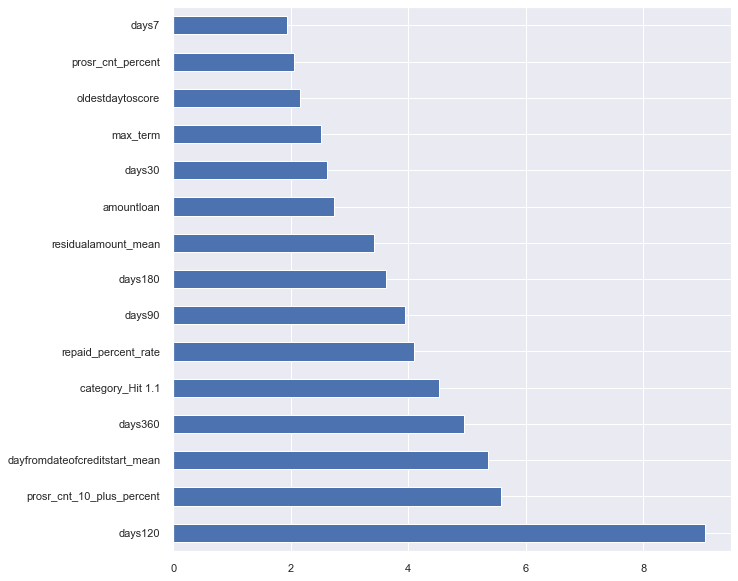

In [69]:
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [225]:
model2 = CatBoostClassifier(eval_metric='AUC',use_best_model=True,random_state=47)

model2.fit(X_train,y_train,eval_set=(X_test,y_test),cat_features=cat_feat, use_best_model=True)
pred2 = model2.predict_proba(X_test)[:,1]
print(roc_auc_score(y_test, pred2))
tpr,fpr,_=roc_curve(y_score=pred2,y_true=y_test)

Learning rate set to 0.109556
0:	test: 0.5541458	best: 0.5541458 (0)	total: 2.3s	remaining: 38m 22s
1:	test: 0.5541458	best: 0.5541458 (0)	total: 2.89s	remaining: 24m 1s
2:	test: 0.6299571	best: 0.6299571 (2)	total: 5.57s	remaining: 30m 52s
3:	test: 0.6291656	best: 0.6299571 (2)	total: 7.02s	remaining: 29m 7s
4:	test: 0.6367342	best: 0.6367342 (4)	total: 8.35s	remaining: 27m 42s
5:	test: 0.7087715	best: 0.7087715 (5)	total: 11.7s	remaining: 32m 20s
6:	test: 0.7113047	best: 0.7113047 (6)	total: 13.7s	remaining: 32m 28s
7:	test: 0.7096722	best: 0.7113047 (6)	total: 15.6s	remaining: 32m 17s
8:	test: 0.7233296	best: 0.7233296 (8)	total: 18.2s	remaining: 33m 24s
9:	test: 0.7349051	best: 0.7349051 (9)	total: 21s	remaining: 34m 34s
10:	test: 0.7431128	best: 0.7431128 (10)	total: 23.5s	remaining: 35m 16s
11:	test: 0.7508950	best: 0.7508950 (11)	total: 26.6s	remaining: 36m 29s
12:	test: 0.7554399	best: 0.7554399 (12)	total: 29.5s	remaining: 37m 17s
13:	test: 0.7574948	best: 0.7574948 (13)	total

112:	test: 0.7950154	best: 0.7950154 (112)	total: 5m 40s	remaining: 44m 31s
113:	test: 0.7950221	best: 0.7950221 (113)	total: 5m 43s	remaining: 44m 26s
114:	test: 0.7950487	best: 0.7950487 (114)	total: 5m 46s	remaining: 44m 26s
115:	test: 0.7952769	best: 0.7952769 (115)	total: 5m 49s	remaining: 44m 24s
116:	test: 0.7952930	best: 0.7952930 (116)	total: 5m 52s	remaining: 44m 21s
117:	test: 0.7953670	best: 0.7953670 (117)	total: 5m 55s	remaining: 44m 19s
118:	test: 0.7953903	best: 0.7953903 (118)	total: 5m 58s	remaining: 44m 16s
119:	test: 0.7953946	best: 0.7953946 (119)	total: 6m 2s	remaining: 44m 17s
120:	test: 0.7953894	best: 0.7953946 (119)	total: 6m 4s	remaining: 44m 9s
121:	test: 0.7954143	best: 0.7954143 (121)	total: 6m 7s	remaining: 44m 5s
122:	test: 0.7954826	best: 0.7954826 (122)	total: 6m 10s	remaining: 44m 1s
123:	test: 0.7955116	best: 0.7955116 (123)	total: 6m 13s	remaining: 43m 55s
124:	test: 0.7955442	best: 0.7955442 (124)	total: 6m 16s	remaining: 43m 52s
125:	test: 0.79560

221:	test: 0.7975116	best: 0.7975222 (220)	total: 11m 7s	remaining: 39m
222:	test: 0.7975396	best: 0.7975396 (222)	total: 11m 10s	remaining: 38m 57s
223:	test: 0.7975377	best: 0.7975396 (222)	total: 11m 14s	remaining: 38m 56s
224:	test: 0.7975285	best: 0.7975396 (222)	total: 11m 17s	remaining: 38m 54s
225:	test: 0.7975096	best: 0.7975396 (222)	total: 11m 20s	remaining: 38m 51s
226:	test: 0.7975084	best: 0.7975396 (222)	total: 11m 24s	remaining: 38m 49s
227:	test: 0.7975148	best: 0.7975396 (222)	total: 11m 26s	remaining: 38m 46s
228:	test: 0.7975485	best: 0.7975485 (228)	total: 11m 29s	remaining: 38m 42s
229:	test: 0.7975418	best: 0.7975485 (228)	total: 11m 32s	remaining: 38m 38s
230:	test: 0.7975169	best: 0.7975485 (228)	total: 11m 35s	remaining: 38m 35s
231:	test: 0.7975045	best: 0.7975485 (228)	total: 11m 39s	remaining: 38m 34s
232:	test: 0.7975318	best: 0.7975485 (228)	total: 11m 41s	remaining: 38m 30s
233:	test: 0.7975182	best: 0.7975485 (228)	total: 11m 44s	remaining: 38m 25s
234:

328:	test: 0.7985589	best: 0.7985877 (317)	total: 16m 32s	remaining: 33m 43s
329:	test: 0.7985524	best: 0.7985877 (317)	total: 16m 35s	remaining: 33m 40s
330:	test: 0.7985565	best: 0.7985877 (317)	total: 16m 37s	remaining: 33m 36s
331:	test: 0.7985696	best: 0.7985877 (317)	total: 16m 40s	remaining: 33m 32s
332:	test: 0.7985572	best: 0.7985877 (317)	total: 16m 44s	remaining: 33m 31s
333:	test: 0.7985471	best: 0.7985877 (317)	total: 16m 47s	remaining: 33m 29s
334:	test: 0.7985457	best: 0.7985877 (317)	total: 16m 50s	remaining: 33m 26s
335:	test: 0.7985792	best: 0.7985877 (317)	total: 16m 53s	remaining: 33m 23s
336:	test: 0.7986798	best: 0.7986798 (336)	total: 16m 56s	remaining: 33m 20s
337:	test: 0.7987440	best: 0.7987440 (337)	total: 17m	remaining: 33m 18s
338:	test: 0.7987680	best: 0.7987680 (338)	total: 17m 3s	remaining: 33m 15s
339:	test: 0.7987822	best: 0.7987822 (339)	total: 17m 6s	remaining: 33m 11s
340:	test: 0.7987932	best: 0.7987932 (340)	total: 17m 9s	remaining: 33m 8s
341:	te

436:	test: 0.7993255	best: 0.7993453 (435)	total: 22m 6s	remaining: 28m 29s
437:	test: 0.7993280	best: 0.7993453 (435)	total: 22m 9s	remaining: 28m 26s
438:	test: 0.7993555	best: 0.7993555 (438)	total: 22m 12s	remaining: 28m 23s
439:	test: 0.7993657	best: 0.7993657 (439)	total: 22m 15s	remaining: 28m 19s
440:	test: 0.7993990	best: 0.7993990 (440)	total: 22m 19s	remaining: 28m 17s
441:	test: 0.7993871	best: 0.7993990 (440)	total: 22m 22s	remaining: 28m 14s
442:	test: 0.7994474	best: 0.7994474 (442)	total: 22m 25s	remaining: 28m 11s
443:	test: 0.7994204	best: 0.7994474 (442)	total: 22m 28s	remaining: 28m 8s
444:	test: 0.7994305	best: 0.7994474 (442)	total: 22m 31s	remaining: 28m 5s
445:	test: 0.7994371	best: 0.7994474 (442)	total: 22m 34s	remaining: 28m 2s
446:	test: 0.7994370	best: 0.7994474 (442)	total: 22m 38s	remaining: 28m
447:	test: 0.7994439	best: 0.7994474 (442)	total: 22m 41s	remaining: 27m 57s
448:	test: 0.7994414	best: 0.7994474 (442)	total: 22m 44s	remaining: 27m 54s
449:	tes

544:	test: 0.7998960	best: 0.7999168 (538)	total: 28m 1s	remaining: 23m 24s
545:	test: 0.7998999	best: 0.7999168 (538)	total: 28m 5s	remaining: 23m 21s
546:	test: 0.7998913	best: 0.7999168 (538)	total: 28m 8s	remaining: 23m 18s
547:	test: 0.7998965	best: 0.7999168 (538)	total: 28m 14s	remaining: 23m 17s
548:	test: 0.7999002	best: 0.7999168 (538)	total: 28m 18s	remaining: 23m 15s
549:	test: 0.7999595	best: 0.7999595 (549)	total: 28m 23s	remaining: 23m 13s
550:	test: 0.7999629	best: 0.7999629 (550)	total: 28m 26s	remaining: 23m 10s
551:	test: 0.7999696	best: 0.7999696 (551)	total: 28m 30s	remaining: 23m 7s
552:	test: 0.7999763	best: 0.7999763 (552)	total: 28m 33s	remaining: 23m 4s
553:	test: 0.7999907	best: 0.7999907 (553)	total: 28m 36s	remaining: 23m 1s
554:	test: 0.8000033	best: 0.8000033 (554)	total: 28m 39s	remaining: 22m 58s
555:	test: 0.7999937	best: 0.8000033 (554)	total: 28m 44s	remaining: 22m 56s
556:	test: 0.8000503	best: 0.8000503 (556)	total: 28m 48s	remaining: 22m 54s
557:	

651:	test: 0.8003936	best: 0.8003936 (651)	total: 36m 8s	remaining: 19m 17s
652:	test: 0.8004053	best: 0.8004053 (652)	total: 36m 11s	remaining: 19m 14s
653:	test: 0.8004094	best: 0.8004094 (653)	total: 36m 15s	remaining: 19m 11s
654:	test: 0.8004311	best: 0.8004311 (654)	total: 36m 19s	remaining: 19m 7s
655:	test: 0.8004589	best: 0.8004589 (655)	total: 36m 22s	remaining: 19m 4s
656:	test: 0.8004607	best: 0.8004607 (656)	total: 36m 26s	remaining: 19m 1s
657:	test: 0.8004218	best: 0.8004607 (656)	total: 36m 29s	remaining: 18m 58s
658:	test: 0.8004330	best: 0.8004607 (656)	total: 36m 33s	remaining: 18m 55s
659:	test: 0.8004449	best: 0.8004607 (656)	total: 36m 37s	remaining: 18m 51s
660:	test: 0.8004446	best: 0.8004607 (656)	total: 36m 40s	remaining: 18m 48s
661:	test: 0.8004483	best: 0.8004607 (656)	total: 36m 45s	remaining: 18m 46s
662:	test: 0.8004392	best: 0.8004607 (656)	total: 36m 48s	remaining: 18m 42s
663:	test: 0.8004429	best: 0.8004607 (656)	total: 36m 52s	remaining: 18m 39s
664

758:	test: 0.8006251	best: 0.8006251 (758)	total: 44m 31s	remaining: 14m 8s
759:	test: 0.8006260	best: 0.8006260 (759)	total: 44m 37s	remaining: 14m 5s
760:	test: 0.8006238	best: 0.8006260 (759)	total: 44m 41s	remaining: 14m 2s
761:	test: 0.8006944	best: 0.8006944 (761)	total: 44m 48s	remaining: 13m 59s
762:	test: 0.8006769	best: 0.8006944 (761)	total: 44m 53s	remaining: 13m 56s
763:	test: 0.8006794	best: 0.8006944 (761)	total: 44m 58s	remaining: 13m 53s
764:	test: 0.8006882	best: 0.8006944 (761)	total: 45m 4s	remaining: 13m 50s
765:	test: 0.8006962	best: 0.8006962 (765)	total: 45m 9s	remaining: 13m 47s
766:	test: 0.8007049	best: 0.8007049 (766)	total: 45m 12s	remaining: 13m 44s
767:	test: 0.8007041	best: 0.8007049 (766)	total: 45m 18s	remaining: 13m 41s
768:	test: 0.8007133	best: 0.8007133 (768)	total: 45m 21s	remaining: 13m 37s
769:	test: 0.8007135	best: 0.8007135 (769)	total: 45m 26s	remaining: 13m 34s
770:	test: 0.8007150	best: 0.8007150 (770)	total: 45m 33s	remaining: 13m 31s
771:

866:	test: 0.8006218	best: 0.8007647 (778)	total: 53m 32s	remaining: 8m 12s
867:	test: 0.8006358	best: 0.8007647 (778)	total: 53m 38s	remaining: 8m 9s
868:	test: 0.8006502	best: 0.8007647 (778)	total: 53m 43s	remaining: 8m 5s
869:	test: 0.8006473	best: 0.8007647 (778)	total: 53m 47s	remaining: 8m 2s
870:	test: 0.8006571	best: 0.8007647 (778)	total: 53m 52s	remaining: 7m 58s
871:	test: 0.8006643	best: 0.8007647 (778)	total: 53m 57s	remaining: 7m 55s
872:	test: 0.8006816	best: 0.8007647 (778)	total: 54m	remaining: 7m 51s
873:	test: 0.8007134	best: 0.8007647 (778)	total: 54m 4s	remaining: 7m 47s
874:	test: 0.8007157	best: 0.8007647 (778)	total: 54m 9s	remaining: 7m 44s
875:	test: 0.8007174	best: 0.8007647 (778)	total: 54m 15s	remaining: 7m 40s
876:	test: 0.8007163	best: 0.8007647 (778)	total: 54m 19s	remaining: 7m 37s
877:	test: 0.8007343	best: 0.8007647 (778)	total: 54m 24s	remaining: 7m 33s
878:	test: 0.8007428	best: 0.8007647 (778)	total: 54m 28s	remaining: 7m 29s
879:	test: 0.8007470	

975:	test: 0.8008896	best: 0.8009500 (953)	total: 1h 2m 12s	remaining: 1m 31s
976:	test: 0.8009090	best: 0.8009500 (953)	total: 1h 2m 17s	remaining: 1m 27s
977:	test: 0.8008991	best: 0.8009500 (953)	total: 1h 2m 21s	remaining: 1m 24s
978:	test: 0.8009012	best: 0.8009500 (953)	total: 1h 2m 27s	remaining: 1m 20s
979:	test: 0.8009240	best: 0.8009500 (953)	total: 1h 2m 31s	remaining: 1m 16s
980:	test: 0.8009330	best: 0.8009500 (953)	total: 1h 2m 35s	remaining: 1m 12s
981:	test: 0.8009299	best: 0.8009500 (953)	total: 1h 2m 41s	remaining: 1m 8s
982:	test: 0.8009303	best: 0.8009500 (953)	total: 1h 2m 45s	remaining: 1m 5s
983:	test: 0.8009608	best: 0.8009608 (983)	total: 1h 2m 49s	remaining: 1m 1s
984:	test: 0.8009278	best: 0.8009608 (983)	total: 1h 2m 52s	remaining: 57.4s
985:	test: 0.8009551	best: 0.8009608 (983)	total: 1h 2m 56s	remaining: 53.6s
986:	test: 0.8009611	best: 0.8009611 (986)	total: 1h 3m 1s	remaining: 49.8s
987:	test: 0.8009636	best: 0.8009636 (987)	total: 1h 3m 6s	remaining: 4

0.8010388643464635


Text(0.5, 1.0, 'Confusion matrix')

Confusion matrix
[[35463    87]
 [ 2306    78]]


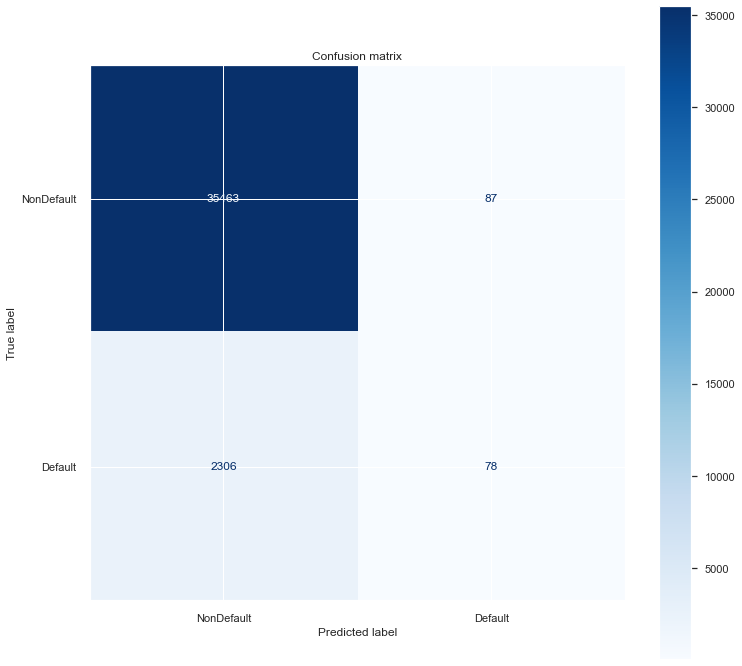

In [226]:
class_names = ['NonDefault', 'Default']

titles_options = [("Confusion matrix", None)]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(model2, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=None)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

C:\Users\aabdraimova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning:

Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.



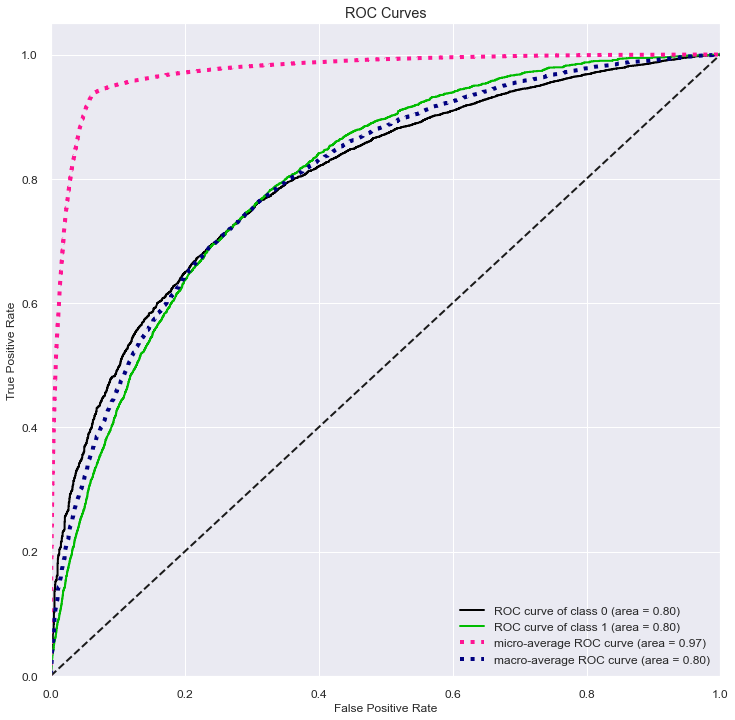

In [227]:
y_probas =model2.predict_proba(X_test)

skplt.metrics.plot_roc_curve(y_test, y_probas)
plt.show()

C:\Users\aabdraimova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning:

Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.



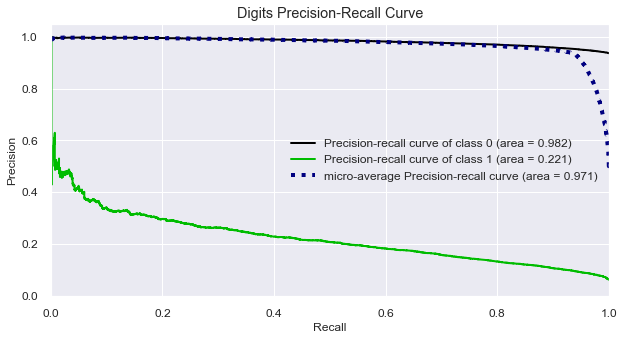

In [228]:
skplt.metrics.plot_precision_recall_curve(y_test, y_probas, title="Digits Precision-Recall Curve", figsize=(10,5));

модель которую мы получили очень плохая. Мы почти не угадали ни одного дефолтного клиента, таким образом все клиенты попали в ошибку второго рода, а это очень плохо для банка. Несмотря на это площадь под ROC кривой оказалась не такой уж плохой. Дело в том что эта кривая плохо оценивает эффективность алгоритма на несбалансированных данных, поэтому добавили Precision-Recall кривую.

In [229]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=47)
X_resampled, y_resampled = ros.fit_resample(X, y)

In [230]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, shuffle=True, random_state=47)

In [232]:
model2 = CatBoostClassifier(eval_metric='AUC',use_best_model=True,random_state=47)

model2.fit(X_train,y_train,eval_set=(X_test,y_test),cat_features=cat_feat,use_best_model=True)
pred2 = model2.predict_proba(X_test)[:,1]
print(roc_auc_score(y_test, pred2))
tpr,fpr,_=roc_curve(y_score=pred2,y_true=y_test)

Learning rate set to 0.127864
0:	test: 0.7526110	best: 0.7526110 (0)	total: 10.5s	remaining: 2h 54m 45s
1:	test: 0.7573240	best: 0.7573240 (1)	total: 21s	remaining: 2h 54m 19s
2:	test: 0.7652564	best: 0.7652564 (2)	total: 27.7s	remaining: 2h 33m 20s
3:	test: 0.7667675	best: 0.7667675 (3)	total: 34.4s	remaining: 2h 22m 57s
4:	test: 0.7716879	best: 0.7716879 (4)	total: 43.5s	remaining: 2h 24m 9s
5:	test: 0.7783715	best: 0.7783715 (5)	total: 49.7s	remaining: 2h 17m 19s
6:	test: 0.7822360	best: 0.7822360 (6)	total: 57.6s	remaining: 2h 16m 8s
7:	test: 0.7850113	best: 0.7850113 (7)	total: 1m 5s	remaining: 2h 15m 11s
8:	test: 0.7875407	best: 0.7875407 (8)	total: 1m 13s	remaining: 2h 15m 6s
9:	test: 0.7895270	best: 0.7895270 (9)	total: 1m 19s	remaining: 2h 11m 24s
10:	test: 0.7915487	best: 0.7915487 (10)	total: 1m 26s	remaining: 2h 9m 3s
11:	test: 0.7930376	best: 0.7930376 (11)	total: 1m 31s	remaining: 2h 6m 13s
12:	test: 0.7944849	best: 0.7944849 (12)	total: 1m 38s	remaining: 2h 4m 7s
13:	tes

107:	test: 0.8868577	best: 0.8868577 (107)	total: 11m 59s	remaining: 1h 39m 4s
108:	test: 0.8871573	best: 0.8871573 (108)	total: 12m 6s	remaining: 1h 38m 57s
109:	test: 0.8880691	best: 0.8880691 (109)	total: 12m 12s	remaining: 1h 38m 49s
110:	test: 0.8881969	best: 0.8881969 (110)	total: 12m 18s	remaining: 1h 38m 34s
111:	test: 0.8883776	best: 0.8883776 (111)	total: 12m 25s	remaining: 1h 38m 30s
112:	test: 0.8896243	best: 0.8896243 (112)	total: 12m 32s	remaining: 1h 38m 24s
113:	test: 0.8897838	best: 0.8897838 (113)	total: 12m 39s	remaining: 1h 38m 19s
114:	test: 0.8899778	best: 0.8899778 (114)	total: 12m 44s	remaining: 1h 38m 6s
115:	test: 0.8911891	best: 0.8911891 (115)	total: 12m 49s	remaining: 1h 37m 45s
116:	test: 0.8920276	best: 0.8920276 (116)	total: 12m 57s	remaining: 1h 37m 44s
117:	test: 0.8922179	best: 0.8922179 (117)	total: 13m 3s	remaining: 1h 37m 34s
118:	test: 0.8941074	best: 0.8941074 (118)	total: 13m 8s	remaining: 1h 37m 17s
119:	test: 0.8942861	best: 0.8942861 (119)	to

210:	test: 0.9196916	best: 0.9196916 (210)	total: 22m 46s	remaining: 1h 25m 9s
211:	test: 0.9197273	best: 0.9197273 (211)	total: 22m 55s	remaining: 1h 25m 10s
212:	test: 0.9199350	best: 0.9199350 (212)	total: 22m 59s	remaining: 1h 24m 57s
213:	test: 0.9200551	best: 0.9200551 (213)	total: 23m 6s	remaining: 1h 24m 53s
214:	test: 0.9200878	best: 0.9200878 (214)	total: 23m 12s	remaining: 1h 24m 45s
215:	test: 0.9204135	best: 0.9204135 (215)	total: 23m 18s	remaining: 1h 24m 36s
216:	test: 0.9204667	best: 0.9204667 (216)	total: 23m 26s	remaining: 1h 24m 35s
217:	test: 0.9210029	best: 0.9210029 (217)	total: 23m 32s	remaining: 1h 24m 27s
218:	test: 0.9211334	best: 0.9211334 (218)	total: 23m 41s	remaining: 1h 24m 28s
219:	test: 0.9212517	best: 0.9212517 (219)	total: 23m 47s	remaining: 1h 24m 19s
220:	test: 0.9215755	best: 0.9215755 (220)	total: 23m 54s	remaining: 1h 24m 16s
221:	test: 0.9216421	best: 0.9216421 (221)	total: 24m	remaining: 1h 24m 7s
222:	test: 0.9217685	best: 0.9217685 (222)	tota

313:	test: 0.9335325	best: 0.9335325 (313)	total: 35m 11s	remaining: 1h 16m 52s
314:	test: 0.9336222	best: 0.9336222 (314)	total: 35m 18s	remaining: 1h 16m 47s
315:	test: 0.9336586	best: 0.9336586 (315)	total: 35m 26s	remaining: 1h 16m 42s
316:	test: 0.9337080	best: 0.9337080 (316)	total: 35m 32s	remaining: 1h 16m 34s
317:	test: 0.9337930	best: 0.9337930 (317)	total: 35m 41s	remaining: 1h 16m 32s
318:	test: 0.9338174	best: 0.9338174 (318)	total: 35m 49s	remaining: 1h 16m 29s
319:	test: 0.9338761	best: 0.9338761 (319)	total: 35m 59s	remaining: 1h 16m 29s
320:	test: 0.9339714	best: 0.9339714 (320)	total: 36m 10s	remaining: 1h 16m 30s
321:	test: 0.9343186	best: 0.9343186 (321)	total: 36m 16s	remaining: 1h 16m 23s
322:	test: 0.9347846	best: 0.9347846 (322)	total: 36m 26s	remaining: 1h 16m 22s
323:	test: 0.9351762	best: 0.9351762 (323)	total: 36m 32s	remaining: 1h 16m 14s
324:	test: 0.9352426	best: 0.9352426 (324)	total: 36m 41s	remaining: 1h 16m 11s
325:	test: 0.9353229	best: 0.9353229 (32

416:	test: 0.9441113	best: 0.9441113 (416)	total: 49m 39s	remaining: 1h 9m 25s
417:	test: 0.9442069	best: 0.9442069 (417)	total: 49m 49s	remaining: 1h 9m 21s
418:	test: 0.9442724	best: 0.9442724 (418)	total: 50m 1s	remaining: 1h 9m 22s
419:	test: 0.9443924	best: 0.9443924 (419)	total: 50m 10s	remaining: 1h 9m 17s
420:	test: 0.9444794	best: 0.9444794 (420)	total: 50m 21s	remaining: 1h 9m 15s
421:	test: 0.9447229	best: 0.9447229 (421)	total: 50m 28s	remaining: 1h 9m 8s
422:	test: 0.9447642	best: 0.9447642 (422)	total: 50m 37s	remaining: 1h 9m 2s
423:	test: 0.9448118	best: 0.9448118 (423)	total: 50m 45s	remaining: 1h 8m 56s
424:	test: 0.9449063	best: 0.9449063 (424)	total: 50m 54s	remaining: 1h 8m 52s
425:	test: 0.9449239	best: 0.9449239 (425)	total: 51m 6s	remaining: 1h 8m 51s
426:	test: 0.9449794	best: 0.9449794 (426)	total: 51m 15s	remaining: 1h 8m 47s
427:	test: 0.9450350	best: 0.9450350 (427)	total: 51m 27s	remaining: 1h 8m 45s
428:	test: 0.9450750	best: 0.9450750 (428)	total: 51m 37

520:	test: 0.9511981	best: 0.9511981 (520)	total: 1h 5m 52s	remaining: 1h 33s
521:	test: 0.9512884	best: 0.9512884 (521)	total: 1h 6m 2s	remaining: 1h 28s
522:	test: 0.9514594	best: 0.9514594 (522)	total: 1h 6m 11s	remaining: 1h 22s
523:	test: 0.9514599	best: 0.9514599 (523)	total: 1h 6m 21s	remaining: 1h 17s
524:	test: 0.9515570	best: 0.9515570 (524)	total: 1h 6m 31s	remaining: 1h 11s
525:	test: 0.9518341	best: 0.9518341 (525)	total: 1h 6m 40s	remaining: 1h 5s
526:	test: 0.9519377	best: 0.9519377 (526)	total: 1h 6m 49s	remaining: 59m 58s
527:	test: 0.9520829	best: 0.9520829 (527)	total: 1h 6m 58s	remaining: 59m 52s
528:	test: 0.9523027	best: 0.9523027 (528)	total: 1h 7m 8s	remaining: 59m 47s
529:	test: 0.9523181	best: 0.9523181 (529)	total: 1h 7m 16s	remaining: 59m 39s
530:	test: 0.9523691	best: 0.9523691 (530)	total: 1h 7m 24s	remaining: 59m 32s
531:	test: 0.9524255	best: 0.9524255 (531)	total: 1h 7m 31s	remaining: 59m 24s
532:	test: 0.9524904	best: 0.9524904 (532)	total: 1h 7m 39s	r

624:	test: 0.9569184	best: 0.9569184 (624)	total: 1h 18m 49s	remaining: 47m 17s
625:	test: 0.9569596	best: 0.9569596 (625)	total: 1h 18m 55s	remaining: 47m 9s
626:	test: 0.9570038	best: 0.9570038 (626)	total: 1h 19m 1s	remaining: 47m
627:	test: 0.9570428	best: 0.9570428 (627)	total: 1h 19m 9s	remaining: 46m 53s
628:	test: 0.9570907	best: 0.9570907 (628)	total: 1h 19m 15s	remaining: 46m 45s
629:	test: 0.9571453	best: 0.9571453 (629)	total: 1h 19m 20s	remaining: 46m 36s
630:	test: 0.9571844	best: 0.9571844 (630)	total: 1h 19m 27s	remaining: 46m 28s
631:	test: 0.9572132	best: 0.9572132 (631)	total: 1h 19m 32s	remaining: 46m 19s
632:	test: 0.9572342	best: 0.9572342 (632)	total: 1h 19m 38s	remaining: 46m 10s
633:	test: 0.9572502	best: 0.9572502 (633)	total: 1h 19m 46s	remaining: 46m 3s
634:	test: 0.9573781	best: 0.9573781 (634)	total: 1h 19m 51s	remaining: 45m 54s
635:	test: 0.9573903	best: 0.9573903 (635)	total: 1h 19m 59s	remaining: 45m 46s
636:	test: 0.9574724	best: 0.9574724 (636)	total

728:	test: 0.9599384	best: 0.9599384 (728)	total: 1h 31m 25s	remaining: 33m 59s
729:	test: 0.9599475	best: 0.9599475 (729)	total: 1h 31m 32s	remaining: 33m 51s
730:	test: 0.9599727	best: 0.9599727 (730)	total: 1h 31m 38s	remaining: 33m 43s
731:	test: 0.9599855	best: 0.9599855 (731)	total: 1h 31m 44s	remaining: 33m 35s
732:	test: 0.9600264	best: 0.9600264 (732)	total: 1h 31m 51s	remaining: 33m 27s
733:	test: 0.9600294	best: 0.9600294 (733)	total: 1h 32m 2s	remaining: 33m 21s
734:	test: 0.9600827	best: 0.9600827 (734)	total: 1h 32m 10s	remaining: 33m 14s
735:	test: 0.9601135	best: 0.9601135 (735)	total: 1h 32m 17s	remaining: 33m 6s
736:	test: 0.9601139	best: 0.9601139 (736)	total: 1h 32m 23s	remaining: 32m 58s
737:	test: 0.9602400	best: 0.9602400 (737)	total: 1h 32m 29s	remaining: 32m 50s
738:	test: 0.9602627	best: 0.9602627 (738)	total: 1h 32m 36s	remaining: 32m 42s
739:	test: 0.9603055	best: 0.9603055 (739)	total: 1h 32m 43s	remaining: 32m 34s
740:	test: 0.9604045	best: 0.9604045 (740)

831:	test: 0.9633792	best: 0.9633792 (831)	total: 1h 43m 20s	remaining: 20m 52s
832:	test: 0.9634070	best: 0.9634070 (832)	total: 1h 43m 26s	remaining: 20m 44s
833:	test: 0.9634235	best: 0.9634235 (833)	total: 1h 43m 31s	remaining: 20m 36s
834:	test: 0.9634428	best: 0.9634428 (834)	total: 1h 43m 36s	remaining: 20m 28s
835:	test: 0.9634435	best: 0.9634435 (835)	total: 1h 43m 40s	remaining: 20m 20s
836:	test: 0.9634623	best: 0.9634623 (836)	total: 1h 43m 45s	remaining: 20m 12s
837:	test: 0.9635030	best: 0.9635030 (837)	total: 1h 43m 49s	remaining: 20m 4s
838:	test: 0.9635444	best: 0.9635444 (838)	total: 1h 43m 55s	remaining: 19m 56s
839:	test: 0.9635376	best: 0.9635444 (838)	total: 1h 44m 2s	remaining: 19m 48s
840:	test: 0.9635643	best: 0.9635643 (840)	total: 1h 44m 7s	remaining: 19m 41s
841:	test: 0.9635792	best: 0.9635792 (841)	total: 1h 44m 13s	remaining: 19m 33s
842:	test: 0.9637426	best: 0.9637426 (842)	total: 1h 44m 21s	remaining: 19m 26s
843:	test: 0.9637533	best: 0.9637533 (843)	

935:	test: 0.9663493	best: 0.9663493 (935)	total: 1h 55m 8s	remaining: 7m 52s
936:	test: 0.9663756	best: 0.9663756 (936)	total: 1h 55m 13s	remaining: 7m 44s
937:	test: 0.9663681	best: 0.9663756 (936)	total: 1h 55m 18s	remaining: 7m 37s
938:	test: 0.9664008	best: 0.9664008 (938)	total: 1h 55m 23s	remaining: 7m 29s
939:	test: 0.9664293	best: 0.9664293 (939)	total: 1h 55m 29s	remaining: 7m 22s
940:	test: 0.9664583	best: 0.9664583 (940)	total: 1h 55m 33s	remaining: 7m 14s
941:	test: 0.9664548	best: 0.9664583 (940)	total: 1h 55m 38s	remaining: 7m 7s
942:	test: 0.9664548	best: 0.9664583 (940)	total: 1h 55m 43s	remaining: 6m 59s
943:	test: 0.9664799	best: 0.9664799 (943)	total: 1h 55m 49s	remaining: 6m 52s
944:	test: 0.9665523	best: 0.9665523 (944)	total: 1h 55m 53s	remaining: 6m 44s
945:	test: 0.9665515	best: 0.9665523 (944)	total: 1h 55m 59s	remaining: 6m 37s
946:	test: 0.9665664	best: 0.9665664 (946)	total: 1h 56m 4s	remaining: 6m 29s
947:	test: 0.9665591	best: 0.9665664 (946)	total: 1h 56

0.9677594832653339


In [233]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=47)

In [234]:
pred2 = model2.predict_proba(X)[:,1]
print(roc_auc_score(y, pred2))
tpr,fpr,_=roc_curve(y_score=pred2,y_true=y)

0.9716312357551398


Text(0.5, 1.0, 'Confusion matrix')

Confusion matrix
[[156827  20460]
 [   882  11501]]


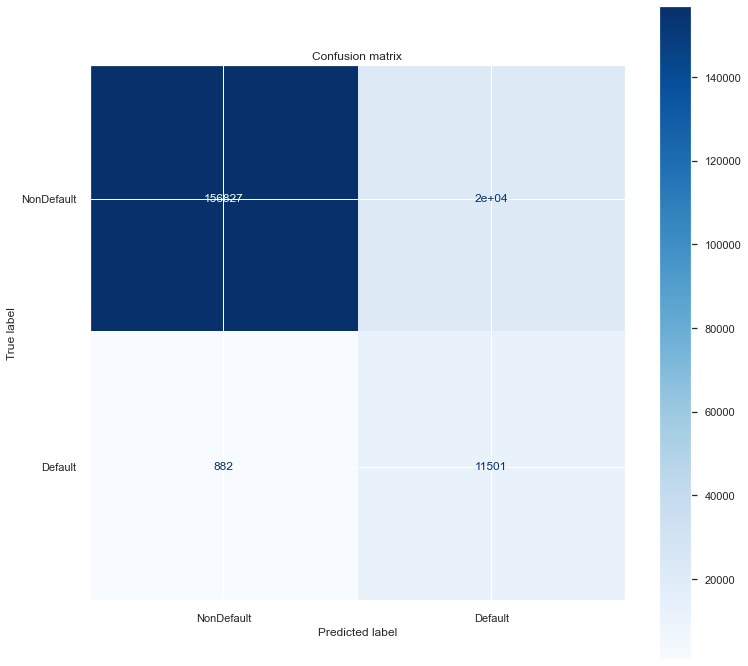

In [235]:
class_names = ['NonDefault', 'Default']

titles_options = [("Confusion matrix", None)]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(model2, X, y,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=None)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

C:\Users\aabdraimova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning:

Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.



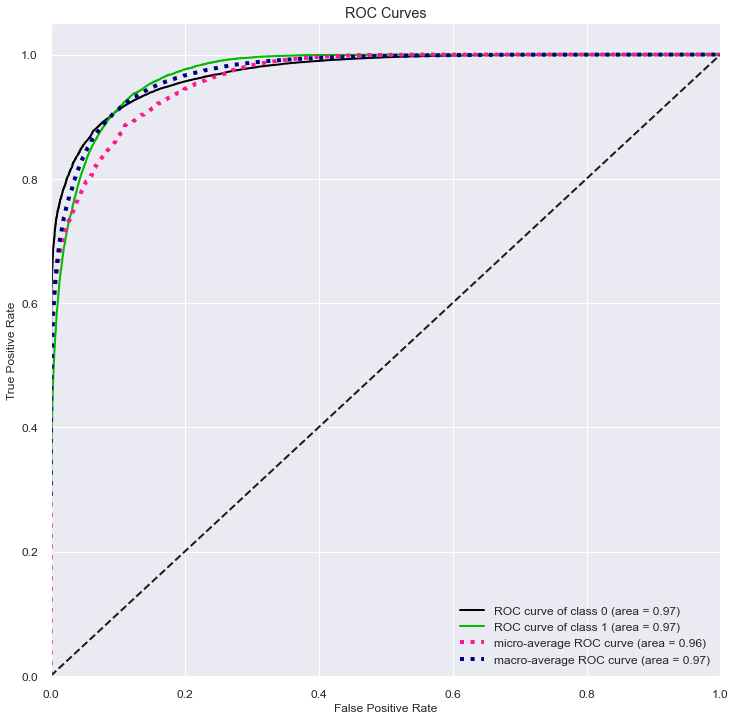

In [236]:
y_probas =model2.predict_proba(X)

skplt.metrics.plot_roc_curve(y, y_probas)
plt.show()

C:\Users\aabdraimova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning:

Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.



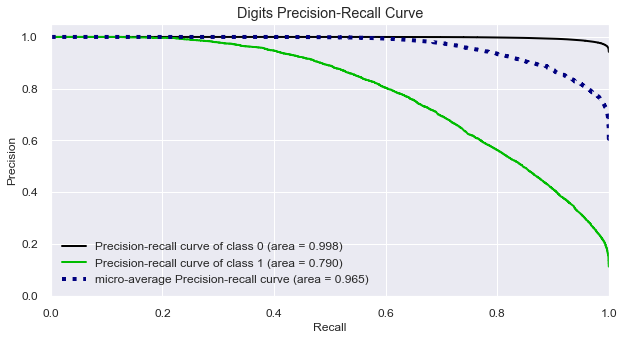

In [237]:
skplt.metrics.plot_precision_recall_curve(y, y_probas, title="Digits Precision-Recall Curve", figsize=(10,5));